In [58]:
import pandas as pd
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from itertools import combinations,product
import numpy as np
import glob

In [59]:
def generate_aspect_df(df,ignore_aspects=["_id","product_type"]):
    
    d= dict()    
    for i in df.doc:
        l=i.split( )
        for i in l: 
            col,val = i.split("-",1)
            if col in ignore_aspects:
                continue
            if col not in d.keys() :
                d[col]=set() 
            d[col].add(val)
          
    d_row =dict.fromkeys(set(d.keys())-set(ignore_aspects)  )     
    for i in d_row:
        d_row[i]=[]

    for i in df.doc:
        s= set() 
        for ii in i.split(): 
            col,val = ii.split("-",1)
            if col == "color" and val=="pattern" and col in s:
                d_row[col][-1]=val
                continue

            if col not in s and col not in ignore_aspects:
                d_row[col].append(val)
                s.add(col)
        
        for jj in set(d.keys())-s:
            d_row[jj].append("Unknown")
        
    df_2 = pd.DataFrame(d_row)
    df_2['class'] = df["class"]
    return df_2  

In [60]:
def show_aspects (df_2):
    for k in df_2.keys():
        print("{} : {}".format(k, df_2[k].unique()))
   

In [61]:
def generate_net(df_2,thresh=0.95):
    
    all_important_features=[] 
    all_reduced_features = []
    
    for k in set(df_2.columns)-set(['class']): 
        
        pos=[]
        neg=[]
        neu=[]
        template=gum.BayesNet()
        g = gum.LabelizedVariable(k, k,0)
        for l in df_2[k].unique():
            g.addLabel(l)
        template.add(g)  
        g_t = gum.RangeVariable("class", "class",0,1)
        template.add(g_t) 
    
        learner = gum.BNLearner("prods_aspects_temp.csv", template)
        learner.setSliceOrder([[k],["class"]])
        bn = learner.learnBN()
        arcs = bn.arcs()
        gnb.showInference(bn,size=5)        
        
        if len(arcs) != 0:
            important_features,reduced_features =  get_important_features(bn,df_2,thresh,k)
            all_important_features.extend(important_features)
            all_reduced_features.extend(reduced_features)
        else:
            all_important_features.extend([(k,"all",0,"no effect")])
            all_reduced_features.extend([(k,[],[],[])])
            
    df,df_r = pd.DataFrame(all_important_features,columns=["aspect","value","k","pos_neg"]),pd.DataFrame(all_reduced_features,columns=["aspect","neg","pos","neu"])                         
    return bn,df,df_r

In [62]:
def get_important_features(bn,df_2,thresh = 1,feature="activity"):
    
    important_features = []
    reduced_features=[]
    neg=[]
    pos=[]
    neu=[]
    
    p = gum.getPosterior(bn, {}, "class").toarray()
    alpha = 10 ** (-2*p[1])
    thresh = thresh * alpha
    
    for s in df_2[feature].unique():
        if s == "Unknown":
            continue
        post_s = gum.getPosterior(bn, {feature:s}, "class").toarray()      
        print('*****',p,post_s,feature,s)
       
        k = (np.log(post_s)-np.log(p)) 
        print (alpha,k)
        
        print('thresh',thresh)
        print(feature,s,post_s)
        print ('k',np.log(post_s)-np.log(p))
        print(post_s[1],(p[1],post_s[1])-p[1]/(1-p[1]))
        if abs(k[1]) > thresh and k[1] < 0 :
            pos_neg = "negative"
            pos.append(s)
            important_features.append((feature,s,k,pos_neg))
        elif abs(k[1]) > thresh and k[1] > 0 :
            pos_neg = "positive"
            neg.append(s)
            important_features.append((feature,s,k,pos_neg))
        else:
            important_features.append((feature,s,k,"neutral"))
            neu.append(s)

    reduced_features.append((feature,pos,neg,neu)) 
    return (important_features,reduced_features)

In [63]:
def generate_aspect_effects(thresh=1):
    dfs=[]
    dfs_r=[]
    for filename in glob.glob('../data_docs/*.csv'):
        print (filename)
        head, tail = os.path.split(filename)
        group = tail.split('#')
        product = group[0]
        gender = group[1]
        dress_code = group[2].split('.')[0].replace("dress_code_","")

        df = pd.read_csv(filename)
        print ("dress code size {}".format(df[df["class"]==1].shape[0]))
        rows=[]
        df_2 = generate_aspect_df(df)
        df_2.to_csv("prods_aspects_temp.csv")
        bn,df_aspects,df_aspects_r = generate_net(df_2,thresh)

        df_aspects["gender"]=gender
        df_aspects["product_type"]= product
        df_aspects["dress_code"]=dress_code

        df_aspects_r["gender"]=gender 
        df_aspects_r["product_type"]=product
        df_aspects_r["dress_code"]=dress_code
        
        dfs.append(df_aspects.copy())
        dfs_r.append(df_aspects_r.copy())

    df_all = pd.concat(dfs)
    df_all_r = pd.concat(dfs_r)  
    df_all.to_csv("shirts_bnf_" +str(thresh) + ".csv")
    df_all_r.to_csv("shirts_bnf_r_"+str(thresh) +".csv")

../data_docs/shirt#female#dress_code_active.csv
dress code size 124


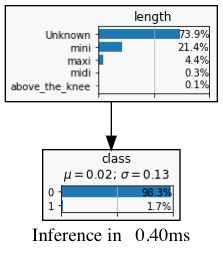

***** [0.98276339 0.01723661] [0.99604717 0.00395283] length mini
0.9236911644828184 [ 0.01342623 -1.47260475]
thresh 0.9236911644828184
length mini [0.99604717 0.00395283]
k [ 0.01342623 -1.47260475]
0.003952825298081907 [-0.00030231 -0.01358609]
***** [0.98276339 0.01723661] [0.99016497 0.00983503] length maxi
0.9236911644828184 [ 0.00750318 -0.5610853 ]
thresh 0.9236911644828184
length maxi [0.99016497 0.00983503]
k [ 0.00750318 -0.5610853 ]
0.00983502538071066 [-0.00030231 -0.00770389]
***** [0.98276339 0.01723661] [0.99528302 0.00471698] length midi
0.9236911644828184 [ 0.01265874 -1.29586633]
thresh 0.9236911644828184
length midi [0.99528302 0.00471698]
k [ 0.01265874 -1.29586633]
0.004716981132075472 [-0.00030231 -0.01282194]
***** [0.98276339 0.01723661] [0.98387097 0.01612903] length above_the_knee
0.9236911644828184 [ 0.00112636 -0.06641444]
thresh 0.9236911644828184
length above_the_knee [0.98387097 0.01612903]
k [ 0.00112636 -0.06641444]
0.01612903225806452 [-0.00030231 -0.

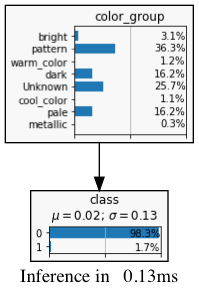

***** [0.98276339 0.01723661] [0.87644469 0.12355531] color_group bright
0.9236911644828184 [-0.1144948   1.96965358]
thresh 0.9236911644828184
color_group bright [0.87644469 0.12355531]
k [-0.1144948   1.96965358]
0.12355531095211887 [-0.00030231  0.10601639]
***** [0.98276339 0.01723661] [0.99081277 0.00918723] color_group pattern
0.9236911644828184 [ 0.00815719 -0.62922102]
thresh 0.9236911644828184
color_group pattern [0.99081277 0.00918723]
k [ 0.00815719 -0.62922102]
0.009187228559156206 [-0.00030231 -0.00835169]
***** [0.98276339 0.01723661] [0.90300752 0.09699248] color_group warm_color
0.9236911644828184 [-0.08463751  1.72759813]
thresh 0.9236911644828184
color_group warm_color [0.90300752 0.09699248]
k [-0.08463751  1.72759813]
0.09699248120300752 [-0.00030231  0.07945356]
***** [0.98276339 0.01723661] [0.97252865 0.02747135] color_group dark
0.9236911644828184 [-0.01046886  0.46610833]
thresh 0.9236911644828184
color_group dark [0.97252865 0.02747135]
k [-0.01046886  0.46610

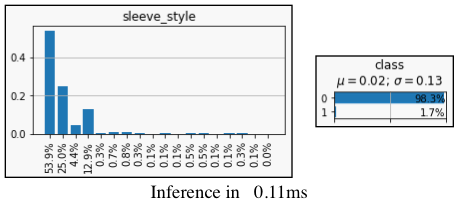

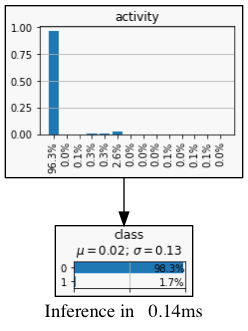

***** [0.98276339 0.01723661] [0.01724138 0.98275862] activity skateboarding
0.9236911644828184 [-4.04305613  4.0433282 ]
thresh 0.9236911644828184
activity skateboarding [0.01724138 0.98275862]
k [-4.04305613  4.0433282 ]
0.9827586206896551 [-3.02311384e-04  9.65219704e-01]
***** [0.98276339 0.01723661] [0.00588235 0.99411765] activity walking
0.9236911644828184 [-5.11841155  4.05482022]
thresh 0.9236911644828184
activity walking [0.00588235 0.99411765]
k [-5.11841155  4.05482022]
0.9941176470588236 [-3.02311384e-04  9.76578730e-01]
***** [0.98276339 0.01723661] [0.00161812 0.99838188] activity gym
0.9236911644828184 [-6.40910157  4.05910051]
thresh 0.9236911644828184
activity gym [0.00161812 0.99838188]
k [-6.40910157  4.05910051]
0.9983818770226537 [-3.02311384e-04  9.80842960e-01]
***** [0.98276339 0.01723661] [0.86842105 0.13157895] activity outdoor
0.9236911644828184 [-0.12369171  2.03257169]
thresh 0.9236911644828184
activity outdoor [0.86842105 0.13157895]
k [-0.12369171  2.032

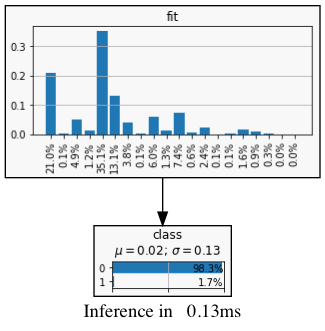

***** [0.98276339 0.01723661] [0.71276596 0.28723404] fit high_rise
0.9236911644828184 [-0.32121528  2.81326203]
thresh 0.9236911644828184
fit high_rise [0.71276596 0.28723404]
k [-0.32121528  2.81326203]
0.28723404255319146 [-0.00030231  0.26969513]
***** [0.98276339 0.01723661] [0.99426427 0.00573573] fit oversized
0.9236911644828184 [ 0.01163464 -1.10032005]
thresh 0.9236911644828184
fit oversized [0.99426427 0.00573573]
k [ 0.01163464 -1.10032005]
0.005735731482792806 [-0.00030231 -0.01180319]
***** [0.98276339 0.01723661] [0.95428734 0.04571266] fit regular_fit
0.9236911644828184 [-0.02940358  0.97534002]
thresh 0.9236911644828184
fit regular_fit [0.95428734 0.04571266]
k [-0.02940358  0.97534002]
0.04571266325951164 [-0.00030231  0.02817375]
***** [0.98276339 0.01723661] [0.99683188 0.00316812] fit regular
0.9236911644828184 [ 0.01421374 -1.69389778]
thresh 0.9236911644828184
fit regular [0.99683188 0.00316812]
k [ 0.01421374 -1.69389778]
0.003168117486824184 [-0.00030231 -0.0143

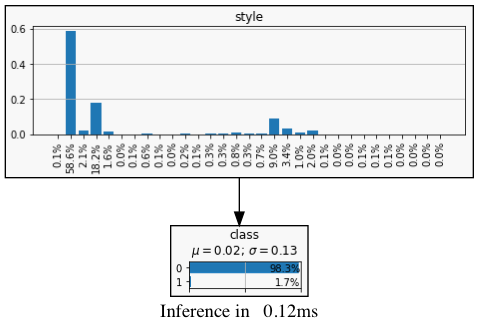

***** [0.98276339 0.01723661] [0.00160772 0.99839228] style sporty
0.9236911644828184 [-6.41555321  4.05911093]
thresh 0.9236911644828184
style sporty [0.00160772 0.99839228]
k [-6.41555321  4.05911093]
0.9983922829581994 [-3.02311384e-04  9.80853366e-01]
***** [0.98276339 0.01723661] [0.97305195 0.02694805] style sexy
0.9236911644828184 [-0.00993092  0.44687567]
thresh 0.9236911644828184
style sexy [0.97305195 0.02694805]
k [-0.00993092  0.44687567]
0.026948051948051943 [-0.00030231  0.00940914]
***** [0.98276339 0.01723661] [9.99987697e-01 1.23025442e-05] style classic
0.9236911644828184 [ 0.01737458 -7.24498453]
thresh 0.9236911644828184
style classic [9.99987697e-01 1.23025442e-05]
k [ 0.01737458 -7.24498453]
1.2302544166133556e-05 [-0.00030231 -0.01752661]
***** [0.98276339 0.01723661] [9.99863351e-01 1.36649358e-04] style feminine
0.9236911644828184 [ 0.01725023 -4.8373724 ]
thresh 0.9236911644828184
style feminine [9.99863351e-01 1.36649358e-04]
k [ 0.01725023 -4.8373724 ]
0.000

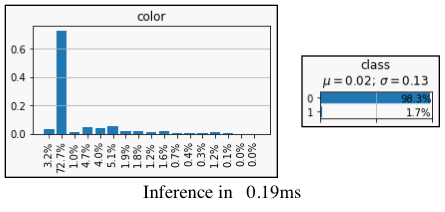

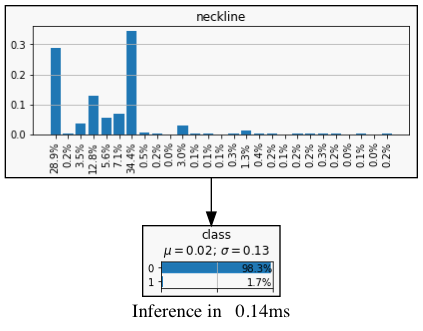

***** [0.98276339 0.01723661] [0.74923077 0.25076923] neckline strapless
0.9236911644828184 [-0.27132135  2.67749778]
thresh 0.9236911644828184
neckline strapless [0.74923077 0.25076923]
k [-0.27132135  2.67749778]
0.25076923076923074 [-0.00030231  0.23323031]
***** [0.98276339 0.01723661] [0.97602538 0.02397462] neckline roundneck
0.9236911644828184 [-0.00687981  0.32996059]
thresh 0.9236911644828184
neckline roundneck [0.97602538 0.02397462]
k [-0.00687981  0.32996059]
0.023974623782826793 [-0.00030231  0.00643571]
***** [0.98276339 0.01723661] [0.99782496 0.00217504] neckline point_collar
0.9236911644828184 [ 0.01520948 -2.06998786]
thresh 0.9236911644828184
neckline point_collar [0.99782496 0.00217504]
k [ 0.01520948 -2.06998786]
0.00217504090673265 [-0.00030231 -0.01536388]
***** [0.98276339 0.01723661] [0.980154 0.019846] neckline button_collar
0.9236911644828184 [-0.00265869  0.14096707]
thresh 0.9236911644828184
neckline button_collar [0.980154 0.019846]
k [-0.00265869  0.14096

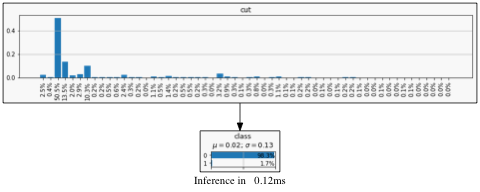

***** [0.98276339 0.01723661] [0.98896301 0.01103699] cut cropped
0.9236911644828187 [ 0.00628854 -0.44578333]
thresh 0.9236911644828187
cut cropped [0.98896301 0.01103699]
k [ 0.00628854 -0.44578333]
0.011036986166977339 [-0.00030231 -0.00650193]
***** [0.98276339 0.01723661] [0.81460674 0.18539326] cut wide
0.9236911644828187 [-0.18766292  2.37544395]
thresh 0.9236911644828187
cut wide [0.81460674 0.18539326]
k [-0.18766292  2.37544395]
0.18539325842696627 [-0.00030231  0.16785434]
***** [0.98276339 0.01723661] [0.99181106 0.00818894] cut pocket
0.9236911644828187 [ 0.00916423 -0.744251  ]
thresh 0.9236911644828187
cut pocket [0.99181106 0.00818894]
k [ 0.00916423 -0.744251  ]
0.008188938998338476 [-0.00030231 -0.00934998]
***** [0.98276339 0.01723661] [0.97254494 0.02745506] cut cuff
0.9236911644828187 [-0.01045211  0.46551504]
thresh 0.9236911644828187
cut cuff [0.97254494 0.02745506]
k [-0.01045211  0.46551504]
0.02745505686682157 [-0.00030231  0.00991614]
***** [0.98276339 0.0172

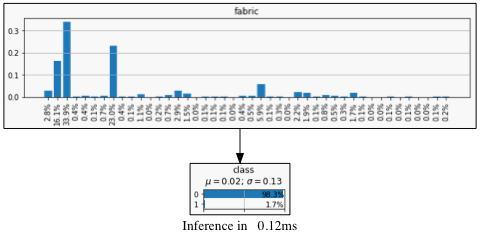

***** [0.98276339 0.01723661] [0.99004387 0.00995613] fabric denim
0.9236911644828185 [ 0.00738087 -0.54884734]
thresh 0.9236911644828185
fabric denim [0.99004387 0.00995613]
k [ 0.00738087 -0.54884734]
0.009956125548430646 [-0.00030231 -0.00758279]
***** [0.98276339 0.01723661] [0.98968116 0.01031884] fabric polyester
0.9236911644828185 [ 0.00701444 -0.51306404]
thresh 0.9236911644828185
fabric polyester [0.98968116 0.01031884]
k [ 0.00701444 -0.51306404]
0.010318839447839585 [-0.00030231 -0.00722008]
***** [0.98276339 0.01723661] [0.37047939 0.62952061] fabric nylon
0.9236911644828185 [-0.97557057  3.59792325]
thresh 0.9236911644828185
fabric nylon [0.37047939 0.62952061]
k [-0.97557057  3.59792325]
0.6295206055508831 [-3.02311384e-04  6.11981689e-01]
***** [0.98276339 0.01723661] [0.90596167 0.09403833] fabric mesh
0.9236911644828185 [-0.08137139  1.69666708]
thresh 0.9236911644828185
fabric mesh [0.90596167 0.09403833]
k [-0.08137139  1.69666708]
0.09403832505322923 [-0.00030231  0

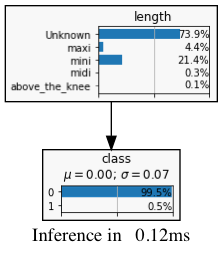

***** [0.99508514 0.00491486] [9.99682741e-01 3.17258883e-04] length maxi
0.9776204763999667 [ 0.00460966 -2.74029949]
thresh 0.9776204763999667
length maxi [9.99682741e-01 3.17258883e-04]
k [ 0.00460966 -2.74029949]
0.000317258883248731 [-2.42751115e-05 -4.62187155e-03]
***** [0.99508514 0.00491486] [9.99935200e-01 6.48004147e-05] length mini
0.9776204763999667 [ 0.00486217 -4.32870559]
thresh 0.9776204763999667
length mini [9.99935200e-01 6.48004147e-05]
k [ 0.00486217 -4.32870559]
6.480041472265424e-05 [-2.42751115e-05 -4.87433002e-03]
***** [0.99508514 0.00491486] [0.99528302 0.00471698] length midi
0.9776204763999667 [ 0.00019883 -0.04109331]
thresh 0.9776204763999667
length midi [0.99528302 0.00471698]
k [ 0.00019883 -0.04109331]
0.004716981132075472 [-2.42751115e-05 -2.22149303e-04]
***** [0.99508514 0.00491486] [0.98387097 0.01612903] length above_the_knee
0.9776204763999667 [-0.01133355  1.18835858]
thresh 0.9776204763999667
length above_the_knee [0.98387097 0.01612903]
k [-0.

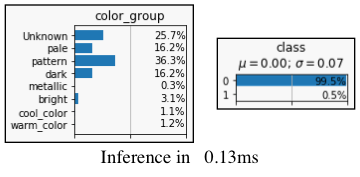

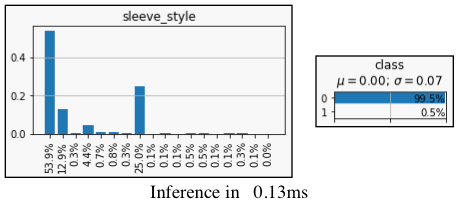

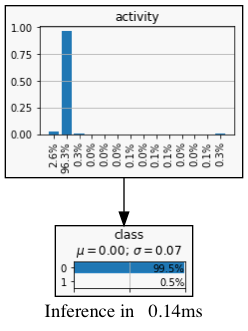

***** [0.99508514 0.00491486] [0.83757009 0.16242991] activity beach
0.9776204763999667 [-0.17232335  3.49798425]
thresh 0.9776204763999667
activity beach [0.83757009 0.16242991]
k [-0.17232335  3.49798425]
0.16242990654205608 [-2.42751115e-05  1.57490776e-01]
***** [0.99508514 0.00491486] [0.99845201 0.00154799] activity outdoor
0.9776204763999667 [ 0.00337779 -1.15530654]
thresh 0.9776204763999667
activity outdoor [0.99845201 0.00154799]
k [ 0.00337779 -1.15530654]
0.0015479876160990713 [-2.42751115e-05 -3.39114282e-03]
***** [0.99508514 0.00491486] [0.96666667 0.03333333] activity jungle
0.9776204763999667 [-0.02897458  1.91429558]
thresh 0.9776204763999667
activity jungle [0.96666667 0.03333333]
k [-0.02897458  1.91429558]
0.033333333333333326 [-2.42751115e-05  2.83942029e-02]
***** [0.99508514 0.00491486] [0.98837209 0.01162791] activity football
0.9776204763999667 [-0.00676907  0.86114567]
thresh 0.9776204763999667
activity football [0.98837209 0.01162791]
k [-0.00676907  0.86114

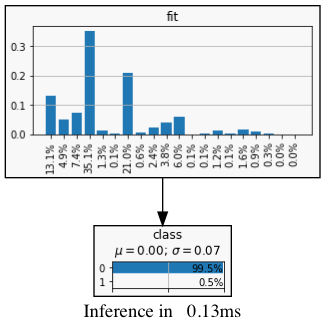

***** [0.99508514 0.00491486] [0.981966 0.018034] fit relaxed
0.9776204763999667 [-0.01327162  1.29999668]
thresh 0.9776204763999667
fit relaxed [0.981966 0.018034]
k [-0.01327162  1.29999668]
0.018034002436311636 [-2.42751115e-05  1.30948720e-02]
***** [0.99508514 0.00491486] [0.98293443 0.01706557] fit oversized
0.9776204763999667 [-0.01228589  1.24480075]
thresh 0.9776204763999667
fit oversized [0.98293443 0.01706557]
k [-0.01228589  1.24480075]
0.01706557144880329 [-2.42751115e-05  1.21264410e-02]
***** [0.99508514 0.00491486] [0.9962294 0.0037706] fit loose
0.9776204763999667 [ 0.00114925 -0.26502854]
thresh 0.9776204763999667
fit loose [0.9962294 0.0037706]
k [ 0.00114925 -0.26502854]
0.0037705986407224655 [-2.42751115e-05 -1.16853179e-03]
***** [0.99508514 0.00491486] [0.99604232 0.00395768] fit regular
0.9776204763999667 [ 0.00096144 -0.21660445]
thresh 0.9776204763999667
fit regular [0.99604232 0.00395768]
k [ 0.00096144 -0.21660445]
0.003957679477309962 [-2.42751115e-05 -9.81

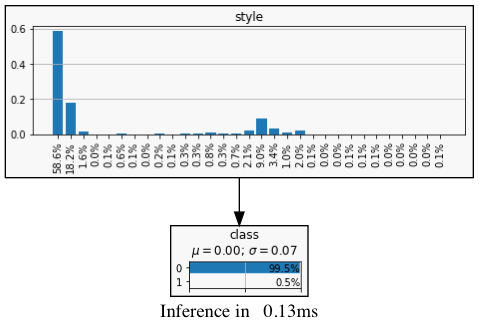

***** [0.99508514 0.00491486] [9.99987697e-01 1.23025442e-05] style classic
0.9776204763999666 [ 4.91467033e-03 -5.99021151e+00]
thresh 0.9776204763999666
style classic [9.99987697e-01 1.23025442e-05]
k [ 4.91467033e-03 -5.99021151e+00]
1.2302544166133556e-05 [-2.42751115e-05 -4.92682789e-03]
***** [0.99508514 0.00491486] [9.99863351e-01 1.36649358e-04] style feminine
0.9776204763999666 [ 0.00479031 -3.58259938]
thresh 0.9776204763999666
style feminine [9.99863351e-01 1.36649358e-04]
k [ 0.00479031 -3.58259938]
0.00013664935774801857 [-2.42751115e-05 -4.80248108e-03]
***** [0.99508514 0.00491486] [0.99468085 0.00531915] style boho
0.9776204763999666 [-0.00040637  0.079051  ]
thresh 0.9776204763999666
style boho [0.99468085 0.00531915]
k [-0.00040637  0.079051  ]
0.005319148936170213 [-2.42751115e-05  3.80018501e-04]
***** [0.99508514 0.00491486] [0.996 0.004] style bohemian
0.9776204763999666 [ 0.00091895 -0.20596796]
thresh 0.9776204763999666
style bohemian [0.996 0.004]
k [ 0.0009189

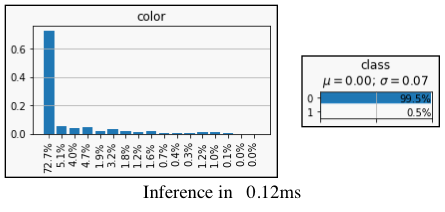

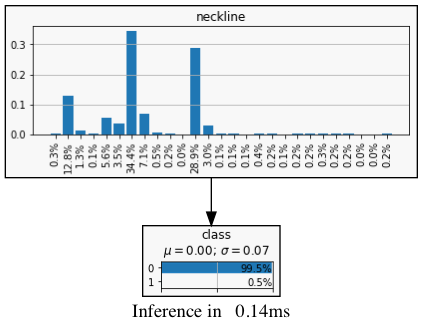

***** [0.99508514 0.00491486] [0.74961479 0.25038521] neckline plunge
0.9776204763999667 [-0.28326884  3.93073825]
thresh 0.9776204763999667
neckline plunge [0.74961479 0.25038521]
k [-0.28326884  3.93073825]
0.2503852080123266 [-2.42751115e-05  2.45446078e-01]
***** [0.99508514 0.00491486] [0.99674742 0.00325258] neckline point_collar
0.9776204763999667 [ 0.00166909 -0.41281253]
thresh 0.9776204763999667
neckline point_collar [0.99674742 0.00325258]
k [ 0.00166909 -0.41281253]
0.003252584108233228 [-2.42751115e-05 -1.68654633e-03]
***** [0.99508514 0.00491486] [0.93460765 0.06539235] neckline reverecollar
0.9776204763999667 [-0.06270149  2.58814302]
thresh 0.9776204763999667
neckline reverecollar [0.93460765 0.06539235]
k [-0.06270149  2.58814302]
0.06539235412474849 [-2.42751115e-05  6.04532237e-02]
***** [0.99508514 0.00491486] [0.71315789 0.28684211] neckline scoopneck
0.9776204763999667 [-0.33312546  4.06666959]
thresh 0.9776204763999667
neckline scoopneck [0.71315789 0.28684211]


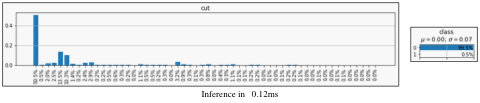

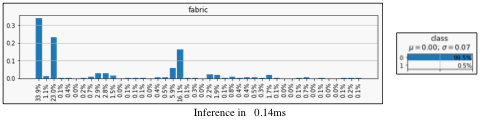

../data_docs/shirt#female#dress_code_business formal.csv
dress code size 18


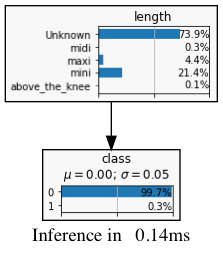

***** [0.99743874 0.00256126] [0.94811321 0.05188679] length midi
0.9882742385991978 [-0.05071682  3.00856392]
thresh 0.9882742385991978
length midi [0.94811321 0.05188679]
k [-0.05071682  3.00856392]
0.0518867924528302 [-6.57691147e-06  4.93189529e-02]
***** [0.99743874 0.00256126] [9.99682741e-01 3.17258883e-04] length maxi
0.9882742385991978 [ 0.00224724 -2.08853753]
thresh 0.9882742385991978
length maxi [9.99682741e-01 3.17258883e-04]
k [ 0.00224724 -2.08853753]
0.000317258883248731 [-6.57691147e-06 -2.25058066e-03]
***** [0.99743874 0.00256126] [9.99935200e-01 6.48004147e-05] length mini
0.9882742385991978 [ 2.49974576e-03 -3.67694363e+00]
thresh 0.9882742385991978
length mini [9.99935200e-01 6.48004147e-05]
k [ 2.49974576e-03 -3.67694363e+00]
6.480041472265424e-05 [-6.57691147e-06 -2.50303913e-03]
***** [0.99743874 0.00256126] [0.98387097 0.01612903] length above_the_knee
0.9882742385991978 [-0.01369597  1.84012054]
thresh 0.9882742385991978
length above_the_knee [0.98387097 0.01

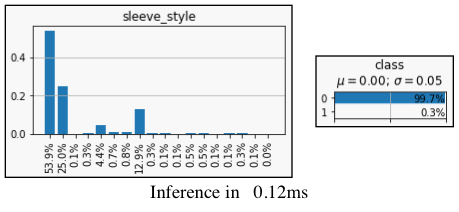

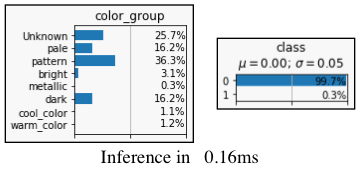

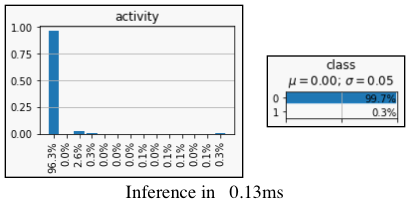

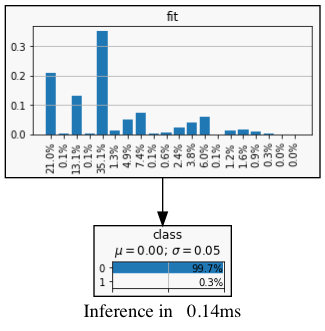

***** [0.99743874 0.00256126] [0.33425414 0.66574586] fit tailored
0.9882742385991978 [-1.09328912  5.56040765]
thresh 0.9882742385991978
fit tailored [0.33425414 0.66574586]
k [-1.09328912  5.56040765]
0.6657458563535912 [-6.57691147e-06  6.63178017e-01]
***** [0.99743874 0.00256126] [0.99573645 0.00426355] fit relaxed
0.9882742385991978 [-0.00170811  0.50960071]
thresh 0.9882742385991978
fit relaxed [0.99573645 0.00426355]
k [-0.00170811  0.50960071]
0.004263545363063398 [-6.57691147e-06  1.69570582e-03]
***** [0.99743874 0.00256126] [0.71276596 0.28723404] fit straight
0.9882742385991978 [-0.33603761  4.71979701]
thresh 0.9882742385991978
fit straight [0.71276596 0.28723404]
k [-0.33603761  4.71979701]
0.28723404255319146 [-6.57691147e-06  2.84666203e-01]
***** [0.99743874 0.00256126] [9.99200568e-01 7.99431515e-04] fit regular
0.9882742385991978 [ 0.0017648  -1.16435476]
thresh 0.9882742385991978
fit regular [9.99200568e-01 7.99431515e-04]
k [ 0.0017648  -1.16435476]
0.000799431515

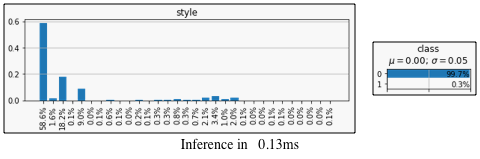

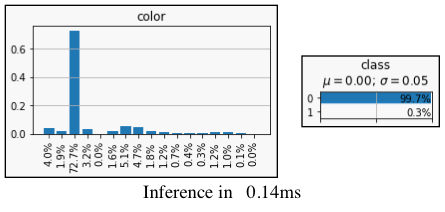

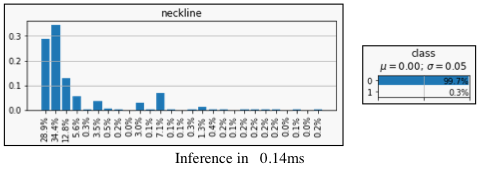

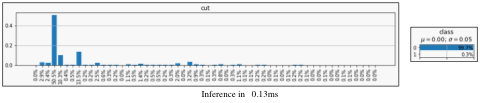

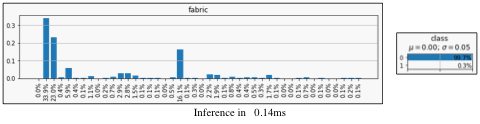

../data_docs/shirt#female#dress_code_casual.csv
dress code size 6460


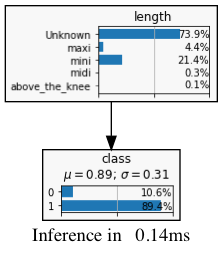

***** [0.10556555 0.89443445] [0.09866751 0.90133249] length maxi
0.016260395659836294 [-0.06757639  0.0076826 ]
thresh 0.016260395659836294
length maxi [0.09866751 0.90133249]
k [-0.06757639  0.0076826 ]
0.9013324873096448 [-7.57835244 -7.5714544 ]
***** [0.10556555 0.89443445] [0.00978486 0.99021514] length mini
0.016260395659836294 [-2.37849557  0.10173062]
thresh 0.016260395659836294
length mini [0.00978486 0.99021514]
k [-2.37849557  0.10173062]
0.9902151373768792 [-7.57835244 -7.48257175]
***** [0.10556555 0.89443445] [0.05188679 0.94811321] length midi
0.016260395659836294 [-0.71026785  0.0582823 ]
thresh 0.016260395659836294
length midi [0.05188679 0.94811321]
k [-0.71026785  0.0582823 ]
0.9481132075471699 [-7.57835244 -7.52467368]
***** [0.10556555 0.89443445] [0.01612903 0.98387097] length above_the_knee
0.016260395659836294 [-1.87871124  0.09530314]
thresh 0.016260395659836294
length above_the_knee [0.01612903 0.98387097]
k [-1.87871124  0.09530314]
0.9838709677419355 [-7.57

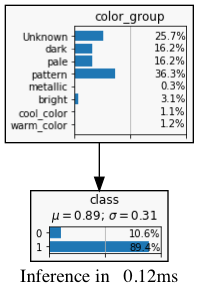

***** [0.10556555 0.89443445] [0.10372711 0.89627289] color_group dark
0.016260395659836304 [-0.01756865  0.00205332]
thresh 0.016260395659836304
color_group dark [0.10372711 0.89627289]
k [-0.01756865  0.00205332]
0.8962728927921174 [-7.57835244 -7.57651399]
***** [0.10556555 0.89443445] [0.1274992 0.8725008] color_group pale
0.016260395659836304 [ 0.18877795 -0.02482804]
thresh 0.016260395659836304
color_group pale [0.1274992 0.8725008]
k [ 0.18877795 -0.02482804]
0.8725008018817492 [-7.57835244 -7.60028608]
***** [0.10556555 0.89443445] [0.08783945 0.91216055] color_group pattern
0.016260395659836304 [-0.18382141  0.0196244 ]
thresh 0.016260395659836304
color_group pattern [0.08783945 0.91216055]
k [-0.18382141  0.0196244 ]
0.9121605498019376 [-7.57835244 -7.56062634]
***** [0.10556555 0.89443445] [0.08918919 0.91081081] color_group metallic
0.016260395659836304 [-0.16857229  0.01814359]
thresh 0.016260395659836304
color_group metallic [0.08918919 0.91081081]
k [-0.16857229  0.01814

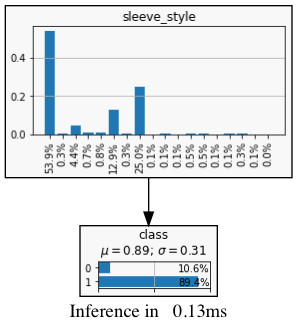

***** [0.10556555 0.89443445] [0.41685912 0.58314088] sleeve_style cold_shoulder
0.016260395659836294 [ 1.3734162  -0.42776281]
thresh 0.016260395659836294
sleeve_style cold_shoulder [0.41685912 0.58314088]
k [ 1.3734162  -0.42776281]
0.5831408775981525 [-7.57835244 -7.88964601]
***** [0.10556555 0.89443445] [0.05087286 0.94912714] sleeve_style sleeveless
0.016260395659836294 [-0.73000251  0.05935115]
thresh 0.016260395659836294
sleeve_style sleeveless [0.05087286 0.94912714]
k [-0.73000251  0.05935115]
0.949127138070887 [-7.57835244 -7.52365975]
***** [0.10556555 0.89443445] [0.31936246 0.68063754] sleeve_style mid_sleeve
0.016260395659836294 [ 1.10699455 -0.27316169]
thresh 0.016260395659836294
sleeve_style mid_sleeve [0.31936246 0.68063754]
k [ 1.10699455 -0.27316169]
0.6806375442739079 [-7.57835244 -7.79214934]
***** [0.10556555 0.89443445] [0.5084666 0.4915334] sleeve_style bellsleeve
0.016260395659836294 [ 1.57206741 -0.59866173]
thresh 0.016260395659836294
sleeve_style bellsleev

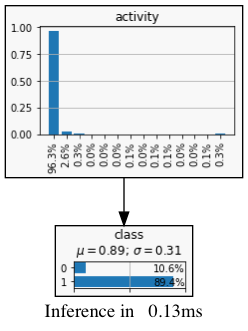

***** [0.10556555 0.89443445] [0.1728972 0.8271028] activity beach
0.016260395659836304 [ 0.49336505 -0.07826262]
thresh 0.016260395659836304
activity beach [0.1728972 0.8271028]
k [ 0.49336505 -0.07826262]
0.8271028037383178 [-7.57835244 -7.64568408]
***** [0.10556555 0.89443445] [0.1749226 0.8250774] activity outdoor
0.016260395659836304 [ 0.50501146 -0.08071441]
thresh 0.016260395659836304
activity outdoor [0.1749226 0.8250774]
k [ 0.50501146 -0.08071441]
0.8250773993808049 [-7.57835244 -7.64770949]
***** [0.10556555 0.89443445] [0.03333333 0.96666667] activity jungle
0.016260395659836304 [-1.15277423  0.07766211]
thresh 0.016260395659836304
activity jungle [0.03333333 0.96666667]
k [-1.15277423  0.07766211]
0.9666666666666666 [-7.57835244 -7.50612022]
***** [0.10556555 0.89443445] [0.3372093 0.6627907] activity football
0.016260395659836304 [ 1.16137168 -0.29973236]
thresh 0.016260395659836304
activity football [0.3372093 0.6627907]
k [ 1.16137168 -0.29973236]
0.6627906976744186 [-

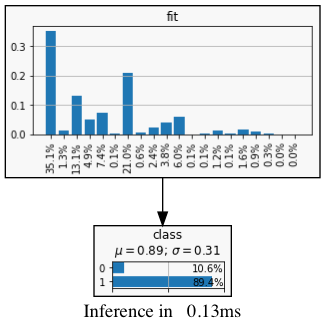

***** [0.10556555 0.89443445] [0.04343578 0.95656422] fit regular
0.016260395659836294 [-0.88804863  0.06715631]
thresh 0.016260395659836294
fit regular [0.04343578 0.95656422]
k [-0.88804863  0.06715631]
0.9565642209984011 [-7.57835244 -7.51622266]
***** [0.10556555 0.89443445] [0.12519521 0.87480479] fit long_line
0.016260395659836294 [ 0.17054208 -0.02219085]
thresh 0.016260395659836294
fit long_line [0.12519521 0.87480479]
k [ 0.17054208 -0.02219085]
0.8748047891723062 [-7.57835244 -7.5979821 ]
***** [0.10556555 0.89443445] [0.07311583 0.92688417] fit relaxed
0.016260395659836294 [-0.36728722  0.03563699]
thresh 0.016260395659836294
fit relaxed [0.07311583 0.92688417]
k [-0.36728722  0.03563699]
0.9268841692706954 [-7.57835244 -7.54590272]
***** [0.10556555 0.89443445] [0.10203937 0.89796063] fit oversized
0.016260395659836294 [-0.0339734   0.00393461]
thresh 0.016260395659836294
fit oversized [0.10203937 0.89796063]
k [-0.0339734   0.00393461]
0.8979606288061182 [-7.57835244 -7.57

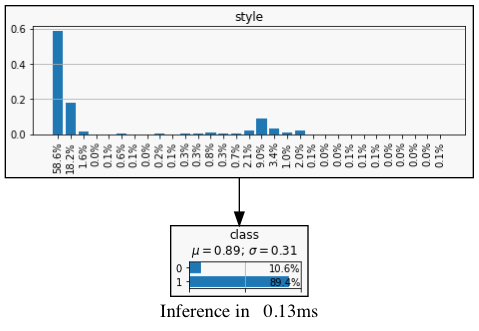

***** [0.10556555 0.89443445] [0.1228163 0.8771837] style classic
0.01626039565983631 [ 0.1513576  -0.01947518]
thresh 0.01626039565983631
style classic [0.1228163 0.8771837]
k [ 0.1513576  -0.01947518]
0.8771837015894887 [-7.57835244 -7.59560318]
***** [0.10556555 0.89443445] [0.05097021 0.94902979] style feminine
0.01626039565983631 [-0.72809078  0.05924857]
thresh 0.01626039565983631
style feminine [0.05097021 0.94902979]
k [-0.72809078  0.05924857]
0.9490297895599891 [-7.57835244 -7.5237571 ]
***** [0.10556555 0.89443445] [0.00531915 0.99468085] style boho
0.01626039565983631 [-2.98801881  0.10623032]
thresh 0.01626039565983631
style boho [0.00531915 0.99468085]
k [-2.98801881  0.10623032]
0.9946808510638298 [-7.57835244 -7.47810603]
***** [0.10556555 0.89443445] [0.5 0.5] style bohemian
0.01626039565983631 [ 1.55527597 -0.58158352]
thresh 0.01626039565983631
style bohemian [0.5 0.5]
k [ 1.55527597 -0.58158352]
0.5 [-7.57835244 -7.97278689]
***** [0.10556555 0.89443445] [0.23275862

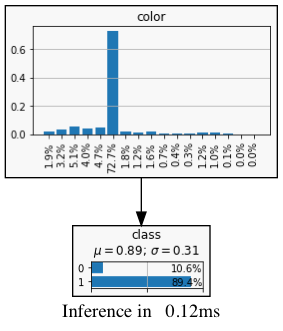

***** [0.10556555 0.89443445] [0.14507882 0.85492118] color pink
0.016260395659836294 [ 0.31794508 -0.04518234]
thresh 0.016260395659836294
color pink [0.14507882 0.85492118]
k [ 0.31794508 -0.04518234]
0.8549211759693225 [-7.57835244 -7.61786571]
***** [0.10556555 0.89443445] [0.23485042 0.76514958] color blue
0.016260395659836294 [ 0.79961668 -0.15612027]
thresh 0.016260395659836294
color blue [0.23485042 0.76514958]
k [ 0.79961668 -0.15612027]
0.7651495781130145 [-7.57835244 -7.70763731]
***** [0.10556555 0.89443445] [0.23373821 0.76626179] color white
0.016260395659836294 [ 0.79486961 -0.15466774]
thresh 0.016260395659836294
color white [0.23373821 0.76626179]
k [ 0.79486961 -0.15466774]
0.7662617867987853 [-7.57835244 -7.7065251 ]
***** [0.10556555 0.89443445] [0.20838439 0.79161561] color black
0.016260395659836294 [ 0.68005226 -0.12211568]
thresh 0.016260395659836294
color black [0.20838439 0.79161561]
k [ 0.68005226 -0.12211568]
0.7916156135130404 [-7.57835244 -7.68117127]
****

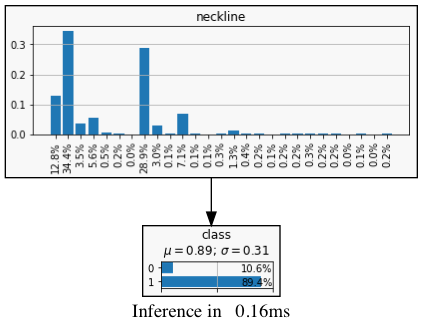

***** [0.10556555 0.89443445] [0.11531708 0.88468292] neckline point_collar
0.016260395659836304 [ 0.0883534  -0.01096231]
thresh 0.016260395659836304
neckline point_collar [0.11531708 0.88468292]
k [ 0.0883534  -0.01096231]
0.8846829229357066 [-7.57835244 -7.58810396]
***** [0.10556555 0.89443445] [0.08008674 0.91991326] neckline collar
0.016260395659836304 [-0.27622181  0.02808777]
thresh 0.016260395659836304
neckline collar [0.08008674 0.91991326]
k [-0.27622181  0.02808777]
0.9199132586145226 [-7.57835244 -7.55287363]
***** [0.10556555 0.89443445] [0.09567719 0.90432281] neckline roundneck
0.016260395659836304 [-0.0983522   0.01099477]
thresh 0.016260395659836304
neckline roundneck [0.09567719 0.90432281]
k [-0.0983522   0.01099477]
0.9043228090882266 [-7.57835244 -7.56846408]
***** [0.10556555 0.89443445] [0.08419653 0.91580347] neckline button_collar
0.016260395659836304 [-0.22617836  0.02361017]
thresh 0.016260395659836304
neckline button_collar [0.08419653 0.91580347]
k [-0.226

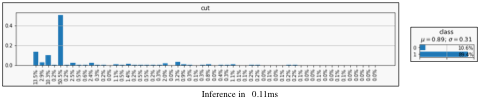

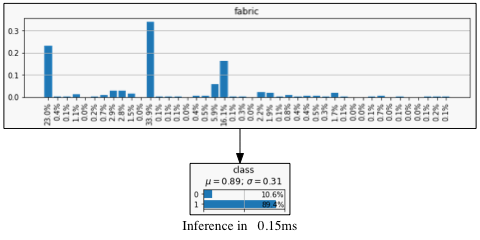

***** [0.10556555 0.89443445] [0.1108487 0.8891513] fabric cotton
0.016260395659836304 [ 0.04883409 -0.0059242 ]
thresh 0.016260395659836304
fabric cotton [0.1108487 0.8891513]
k [ 0.04883409 -0.0059242 ]
0.889151298585726 [-7.57835244 -7.58363559]
***** [0.10556555 0.89443445] [4.20521447e-04 9.99579479e-01] fabric wovencotton
0.016260395659836304 [-5.52559193  0.11114305]
thresh 0.016260395659836304
fabric wovencotton [4.20521447e-04 9.99579479e-01]
k [-5.52559193  0.11114305]
0.9995794785534062 [-7.57835244 -7.47320741]
***** [0.10556555 0.89443445] [0.28640777 0.71359223] fabric twill
0.016260395659836304 [ 0.99808442 -0.22587992]
thresh 0.016260395659836304
fabric twill [0.28640777 0.71359223]
k [ 0.99808442 -0.22587992]
0.7135922330097088 [-7.57835244 -7.75919465]
***** [0.10556555 0.89443445] [0.17082294 0.82917706] fabric woven
0.016260395659836304 [ 0.48129547 -0.0757579 ]
thresh 0.016260395659836304
fabric woven [0.17082294 0.82917706]
k [ 0.48129547 -0.0757579 ]
0.8291770573

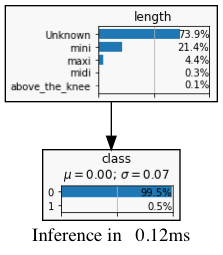

***** [0.99508514 0.00491486] [9.99287195e-01 7.12804562e-04] length mini
0.9776204763999667 [ 0.00421391 -1.93081032]
thresh 0.9776204763999667
length mini [9.99287195e-01 7.12804562e-04]
k [ 0.00421391 -1.93081032]
0.0007128045619491966 [-2.42751115e-05 -4.22632587e-03]
***** [0.99508514 0.00491486] [9.99682741e-01 3.17258883e-04] length maxi
0.9776204763999667 [ 0.00460966 -2.74029949]
thresh 0.9776204763999667
length maxi [9.99682741e-01 3.17258883e-04]
k [ 0.00460966 -2.74029949]
0.000317258883248731 [-2.42751115e-05 -4.62187155e-03]
***** [0.99508514 0.00491486] [0.99528302 0.00471698] length midi
0.9776204763999667 [ 0.00019883 -0.04109331]
thresh 0.9776204763999667
length midi [0.99528302 0.00471698]
k [ 0.00019883 -0.04109331]
0.004716981132075472 [-2.42751115e-05 -2.22149303e-04]
***** [0.99508514 0.00491486] [0.98387097 0.01612903] length above_the_knee
0.9776204763999667 [-0.01133355  1.18835858]
thresh 0.9776204763999667
length above_the_knee [0.98387097 0.01612903]
k [-0.

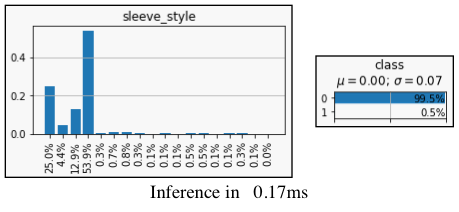

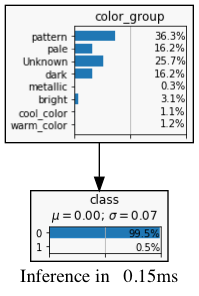

***** [0.99508514 0.00491486] [0.99004916 0.00995084] color_group pattern
0.9776204763999667 [-0.00507371  0.70539489]
thresh 0.9776204763999667
color_group pattern [0.99004916 0.00995084]
k [-0.00507371  0.70539489]
0.009950842361475684 [-2.42751115e-05  5.01171193e-03]
***** [0.99508514 0.00491486] [0.99224848 0.00775152] color_group pale
0.9776204763999667 [-0.00285475  0.4556271 ]
thresh 0.9776204763999667
color_group pale [0.99224848 0.00775152]
k [-0.00285475  0.4556271 ]
0.007751523575323426 [-2.42751115e-05  2.81239314e-03]
***** [0.99508514 0.00491486] [9.99946450e-01 5.35503909e-05] color_group dark
0.9776204763999667 [ 0.00487342 -4.5193945 ]
thresh 0.9776204763999667
color_group dark [9.99946450e-01 5.35503909e-05]
k [ 0.00487342 -4.5193945 ]
5.35503909178537e-05 [-2.42751115e-05 -4.88558004e-03]
***** [0.99508514 0.00491486] [0.9972973 0.0027027] color_group metallic
0.9776204763999667 [ 0.00222061 -0.59801004]
thresh 0.9776204763999667
color_group metallic [0.9972973 0.00

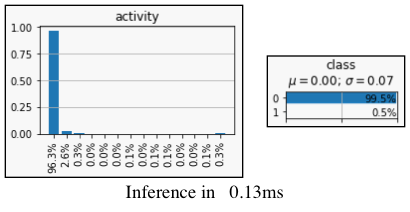

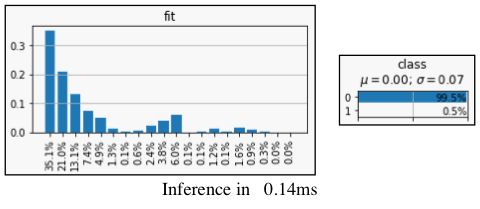

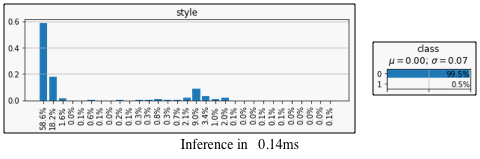

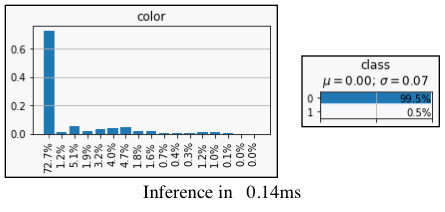

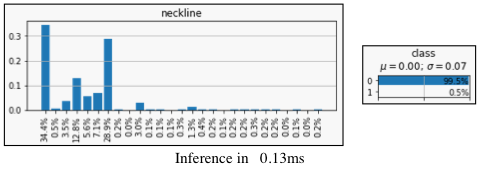

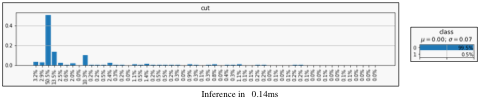

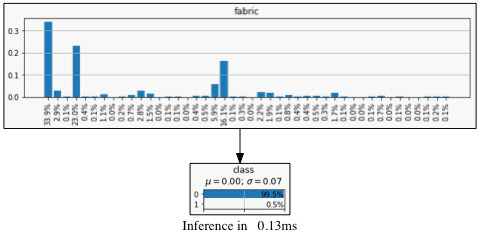

***** [0.99508514 0.00491486] [0.99522993 0.00477007] fabric lace
0.9776204763999667 [ 0.00014549 -0.02990096]
thresh 0.9776204763999667
fabric lace [0.99522993 0.00477007]
k [ 0.00014549 -0.02990096]
0.00477007181905885 [-2.42751115e-05 -1.69058616e-04]
***** [0.99508514 0.00491486] [0.55541562 0.44458438] fabric delicate
0.9776204763999667 [-0.58311161  4.50487756]
thresh 0.9776204763999667
fabric delicate [0.55541562 0.44458438]
k [-0.58311161  4.50487756]
0.4445843828715365 [-2.42751115e-05  4.39645252e-01]
***** [0.99508514 0.00491486] [9.99993155e-01 6.84547035e-06] fabric cotton
0.9776204763999667 [ 4.92012745e-03 -6.57643043e+00]
thresh 0.9776204763999667
fabric cotton [9.99993155e-01 6.84547035e-06]
k [ 4.92012745e-03 -6.57643043e+00]
6.845470352267905e-06 [-2.42751115e-05 -4.93228496e-03]
***** [0.99508514 0.00491486] [9.99579479e-01 4.20521447e-04] fabric wovencotton
0.9776204763999667 [ 0.00450636 -2.45852212]
thresh 0.9776204763999667
fabric wovencotton [9.99579479e-01 4.2

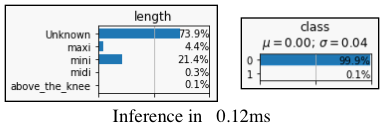

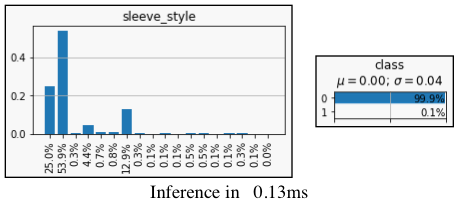

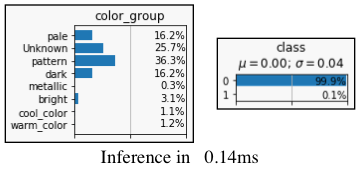

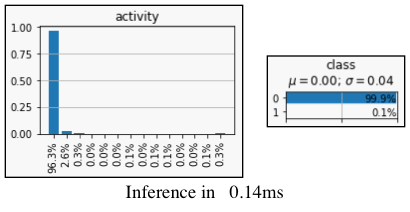

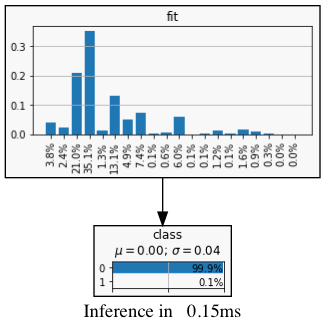

***** [0.99854631 0.00145369] [0.99271714 0.00728286] fit slim
0.9933278701470913 [-0.00585477  1.61141915]
thresh 0.9933278701470913
fit slim [0.99271714 0.00728286]
k [-0.00585477  1.61141915]
0.007282862794461428 [-2.11628989e-06  5.82705690e-03]
***** [0.99854631 0.00145369] [0.96477638 0.03522362] fit classicfit
0.9933278701470913 [-0.03440419  3.18761197]
thresh 0.9933278701470913
fit classicfit [0.96477638 0.03522362]
k [-0.03440419  3.18761197]
0.035223618824905 [-2.11628989e-06  3.37678129e-02]
***** [0.99854631 0.00145369] [9.99990130e-01 9.86952488e-06] fit regular
0.9933278701470913 [ 1.44487766e-03 -4.99240844e+00]
thresh 0.9933278701470913
fit regular [9.99990130e-01 9.86952488e-06]
k [ 1.44487766e-03 -4.99240844e+00]
9.869524881072227e-06 [-2.11628989e-06 -1.44593637e-03]
***** [0.99854631 0.00145369] [9.99739719e-01 2.60281104e-04] fit long_line
0.9933278701470913 [ 1.19443225e-03 -1.72009794e+00]
thresh 0.9933278701470913
fit long_line [9.99739719e-01 2.60281104e-04]
k

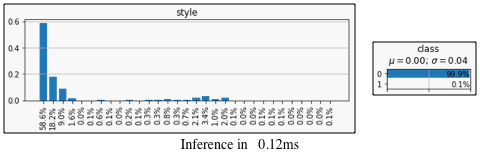

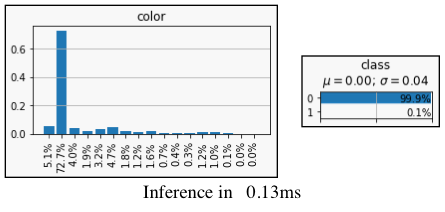

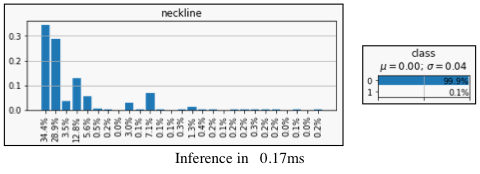

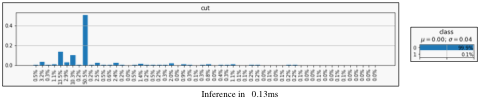

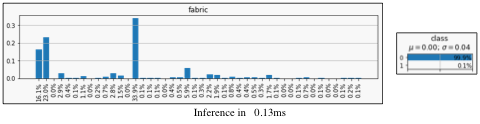

../data_docs/shirt#female#dress_code_dressy casual.csv
dress code size 536


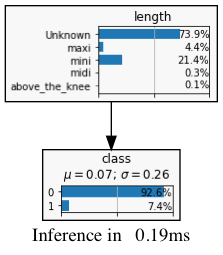

***** [0.92572338 0.07427662] [0.91085025 0.08914975] length maxi
0.7103081001518317 [-0.01619696  0.18252131]
thresh 0.7103081001518317
length maxi [0.91085025 0.08914975]
k [-0.01619696  0.18252131]
0.0891497461928934 [-0.00595968  0.00891345]
***** [0.92572338 0.07427662] [0.99475117 0.00524883] length mini
0.7103081001518317 [ 0.07191715 -2.6497903 ]
thresh 0.7103081001518317
length mini [0.99475117 0.00524883]
k [ 0.07191715 -2.6497903 ]
0.005248833592534992 [-0.00595968 -0.07498746]
***** [0.92572338 0.07427662] [0.99528302 0.00471698] length midi
0.7103081001518317 [ 0.07245167 -2.75662718]
thresh 0.7103081001518317
length midi [0.99528302 0.00471698]
k [ 0.07245167 -2.75662718]
0.004716981132075472 [-0.00595968 -0.07551932]
***** [0.92572338 0.07427662] [0.98387097 0.01612903] length above_the_knee
0.7103081001518317 [ 0.06091929 -1.52717529]
thresh 0.7103081001518317
length above_the_knee [0.98387097 0.01612903]
k [ 0.06091929 -1.52717529]
0.01612903225806452 [-0.00595968 -0.0

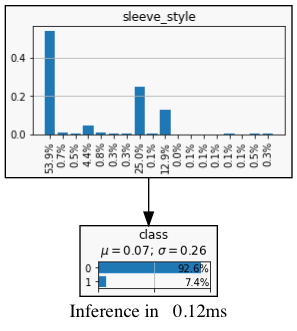

***** [0.92572338 0.07427662] [0.68063754 0.31936246] sleeve_style mid_sleeve
0.7103081001518315 [-0.30754554  1.4585305 ]
thresh 0.7103081001518315
sleeve_style mid_sleeve [0.68063754 0.31936246]
k [-0.30754554  1.4585305 ]
0.3193624557260921 [-0.00595968  0.23912616]
***** [0.92572338 0.07427662] [0.94375963 0.05624037] sleeve_style capsleeve
0.7103081001518315 [ 0.01929604 -0.27816136]
thresh 0.7103081001518315
sleeve_style capsleeve [0.94375963 0.05624037]
k [ 0.01929604 -0.27816136]
0.056240369799691825 [-0.00595968 -0.02399593]
***** [0.92572338 0.07427662] [0.96182331 0.03817669] sleeve_style sleeveless
0.7103081001518315 [ 0.0382553 -0.6655711]
thresh 0.7103081001518315
sleeve_style sleeveless [0.96182331 0.03817669]
k [ 0.0382553 -0.6655711]
0.03817668841474167 [-0.00595968 -0.04205961]
***** [0.92572338 0.07427662] [0.4915334 0.5084666] sleeve_style bellsleeve
0.7103081001518315 [-0.63304558  1.92360335]
thresh 0.7103081001518315
sleeve_style bellsleeve [0.4915334 0.5084666]


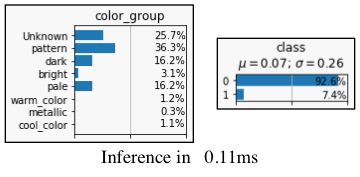

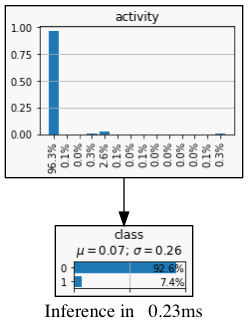

***** [0.92572338 0.07427662] [0.00588235 0.99411765] activity rock
0.7103081001518317 [-5.05861863  2.59405937]
thresh 0.7103081001518317
activity rock [0.00588235 0.99411765]
k [-5.05861863  2.59405937]
0.9941176470588236 [-0.00595968  0.91388135]
***** [0.92572338 0.07427662] [0.03333333 0.96666667] activity city
0.7103081001518317 [-3.32401757  2.56605754]
thresh 0.7103081001518317
activity city [0.03333333 0.96666667]
k [-3.32401757  2.56605754]
0.9666666666666666 [-0.00595968  0.88643037]
***** [0.92572338 0.07427662] [0.95510836 0.04489164] activity outdoor
0.7103081001518317 [ 0.03124933 -0.50354458]
thresh 0.7103081001518317
activity outdoor [0.95510836 0.04489164]
k [ 0.03124933 -0.50354458]
0.04489164086687307 [-0.00595968 -0.03534466]
***** [0.92572338 0.07427662] [0.98934579 0.01065421] activity beach
0.7103081001518317 [ 0.06646844 -1.94184148]
thresh 0.7103081001518317
activity beach [0.98934579 0.01065421]
k [ 0.06646844 -1.94184148]
0.010654205607476637 [-0.00595968 -0

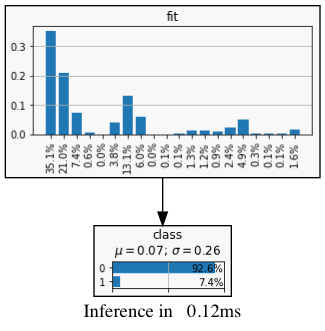

***** [0.92572338 0.07427662] [0.96998677 0.03001323] fit regular
0.7103081001518315 [ 0.04670697 -0.90615806]
thresh 0.7103081001518315
fit regular [0.96998677 0.03001323]
k [ 0.04670697 -0.90615806]
0.03001322516334064 [-0.00595968 -0.05022307]
***** [0.92572338 0.07427662] [0.94036868 0.05963132] fit loose
0.7103081001518315 [ 0.01569654 -0.21961526]
thresh 0.7103081001518315
fit loose [0.94036868 0.05963132]
k [ 0.01569654 -0.21961526]
0.05963131924401825 [-0.00595968 -0.02060498]
***** [0.92572338 0.07427662] [0.5 0.5] fit skinny
0.7103081001518315 [-0.61596737  1.90681192]
thresh 0.7103081001518315
fit skinny [0.5 0.5]
k [-0.61596737  1.90681192]
0.5 [-0.00595968  0.4197637 ]
***** [0.92572338 0.07427662] [0.02380952 0.97619048] fit contemporaryfit
0.7103081001518315 [-3.66048981  2.57586154]
thresh 0.7103081001518315
fit contemporaryfit [0.02380952 0.97619048]
k [-3.66048981  2.57586154]
0.9761904761904762 [-0.00595968  0.89595418]
***** [0.92572338 0.07427662] [0.83087574 0.169

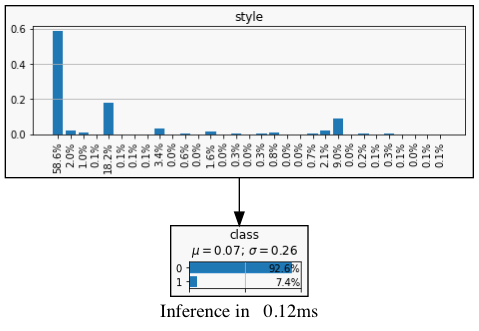

***** [0.92572338 0.07427662] [0.4761957 0.5238043] style stylish
0.7103081001518313 [-0.66474656  1.95332196]
thresh 0.7103081001518313
style stylish [0.4761957 0.5238043]
k [-0.66474656  1.95332196]
0.5238043001316367 [-0.00595968  0.443568  ]
***** [0.92572338 0.07427662] [0.12693006 0.87306994] style chic
0.7103081001518313 [-1.98693921  2.46421948]
thresh 0.7103081001518313
style chic [0.12693006 0.87306994]
k [-1.98693921  2.46421948]
0.873069936421435 [-0.00595968  0.79283364]
***** [0.92572338 0.07427662] [0.5 0.5] style peasant
0.7103081001518313 [-0.61596737  1.90681192]
thresh 0.7103081001518313
style peasant [0.5 0.5]
k [-0.61596737  1.90681192]
0.5 [-0.00595968  0.4197637 ]
***** [0.92572338 0.07427662] [0.88481128 0.11518872] style classic
0.7103081001518313 [-0.04520109  0.43877565]
thresh 0.7103081001518313
style classic [0.88481128 0.11518872]
k [-0.04520109  0.43877565]
0.1151887210275085 [-0.00595968  0.03495242]
***** [0.92572338 0.07427662] [0.14449541 0.85550459] 

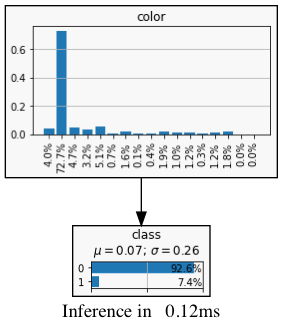

***** [0.92572338 0.07427662] [0.95693085 0.04306915] color pattern
0.7103081001518315 [ 0.03315567 -0.54498931]
thresh 0.7103081001518315
color pattern [0.95693085 0.04306915]
k [ 0.03315567 -0.54498931]
0.04306914601477296 [-0.00595968 -0.03716715]
***** [0.92572338 0.07427662] [0.84815333 0.15184667] color black
0.7103081001518315 [-0.08751403  0.71507505]
thresh 0.7103081001518315
color black [0.84815333 0.15184667]
k [-0.08751403  0.71507505]
0.15184666549973747 [-0.00595968  0.07161037]
***** [0.92572338 0.07427662] [0.81296344 0.18703656] color blue
0.7103081001518315 [-0.12988933  0.92350794]
thresh 0.7103081001518315
color blue [0.81296344 0.18703656]
k [-0.12988933  0.92350794]
0.1870365635387369 [-0.00595968  0.10680027]
***** [0.92572338 0.07427662] [0.81245006 0.18754994] color white
0.7103081001518315 [-0.13052103  0.926249  ]
thresh 0.7103081001518315
color white [0.81245006 0.18754994]
k [-0.13052103  0.926249  ]
0.18754994406264985 [-0.00595968  0.10731365]
***** [0.92

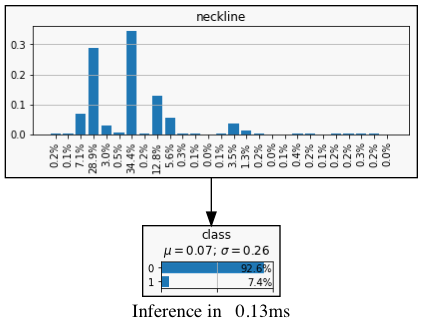

***** [0.92572338 0.07427662] [0.58307692 0.41692308] neckline halter_neck
0.7103081001518314 [-0.46225635  1.72510555]
thresh 0.7103081001518314
neckline halter_neck [0.58307692 0.41692308]
k [-0.46225635  1.72510555]
0.4169230769230769 [-0.00595968  0.33668678]
***** [0.92572338 0.07427662] [0.28684211 0.71315789] neckline scoopneck
0.7103081001518314 [-1.17164356  2.26190666]
thresh 0.7103081001518314
neckline scoopneck [0.28684211 0.71315789]
k [-1.17164356  2.26190666]
0.7131578947368421 [-0.00595968  0.6329216 ]
***** [0.92572338 0.07427662] [0.96467214 0.03532786] neckline v_neck
0.7103081001518314 [ 0.04121282 -0.74312421]
thresh 0.7103081001518314
neckline v_neck [0.96467214 0.03532786]
k [ 0.04121282 -0.74312421]
0.03532786290029773 [-0.00595968 -0.04490843]
***** [0.92572338 0.07427662] [0.91620737 0.08379263] neckline off_the_shoulder
0.7103081001518314 [-0.01033274  0.12054885]
thresh 0.7103081001518314
neckline off_the_shoulder [0.91620737 0.08379263]
k [-0.01033274  0.12

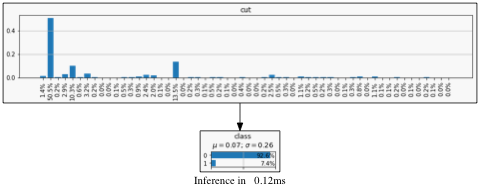

***** [0.92572338 0.07427662] [0.87248381 0.12751619] cut cutout
0.7103081001518313 [-0.05923137  0.54044716]
thresh 0.7103081001518313
cut cutout [0.87248381 0.12751619]
k [-0.05923137  0.54044716]
0.1275161911430072 [-0.00595968  0.04727989]
***** [0.92572338 0.07427662] [0.73305589 0.26694411] cut cut_out
0.7103081001518313 [-0.23335353  1.27924314]
thresh 0.7103081001518313
cut cut_out [0.73305589 0.26694411]
k [-0.23335353  1.27924314]
0.2669441141498216 [-0.00595968  0.18670782]
***** [0.92572338 0.07427662] [0.90381149 0.09618851] cut ruffle
0.7103081001518313 [-0.02395466  0.25851377]
thresh 0.7103081001518313
cut ruffle [0.90381149 0.09618851]
k [-0.02395466  0.25851377]
0.09618851403553952 [-0.00595968  0.01595222]
***** [0.92572338 0.07427662] [0.84521378 0.15478622] cut button
0.7103081001518313 [-0.09098588  0.73424878]
thresh 0.7103081001518313
cut button [0.84521378 0.15478622]
k [-0.09098588  0.73424878]
0.15478622413420173 [-0.00595968  0.07454993]
***** [0.92572338 0.

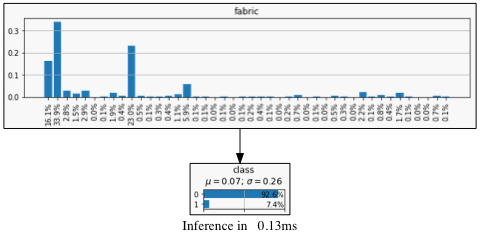

***** [0.92572338 0.07427662] [0.96648574 0.03351426] fabric polyester
0.7103081001518314 [ 0.04309107 -0.79582508]
thresh 0.7103081001518314
fabric polyester [0.96648574 0.03351426]
k [ 0.04309107 -0.79582508]
0.0335142628424156 [-0.00595968 -0.04672203]
***** [0.92572338 0.07427662] [0.82669592 0.17330408] fabric denim
0.7103081001518314 [-0.11313854  0.84725158]
thresh 0.7103081001518314
fabric denim [0.82669592 0.17330408]
k [-0.11313854  0.84725158]
0.17330408369895378 [-0.00595968  0.09306779]
***** [0.92572338 0.07427662] [0.98138018 0.01861982] fabric knitted
0.7103081001518314 [ 0.05838446 -1.38356963]
thresh 0.7103081001518314
fabric knitted [0.98138018 0.01861982]
k [ 0.05838446 -1.38356963]
0.018619819061645275 [-0.00595968 -0.06161648]
***** [0.92572338 0.07427662] [0.91033337 0.08966663] fabric lace
0.7103081001518314 [-0.0167646   0.18830251]
thresh 0.7103081001518314
fabric lace [0.91033337 0.08966663]
k [-0.0167646   0.18830251]
0.08966663093579164 [-0.00595968  0.0094

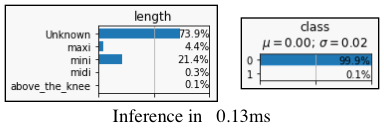

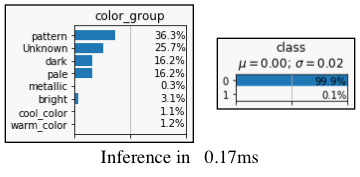

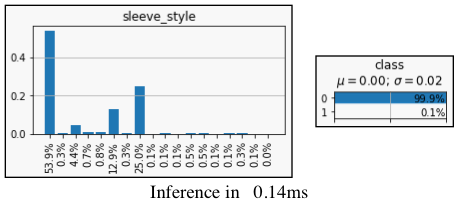

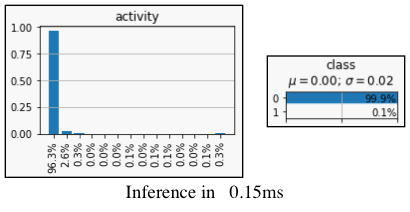

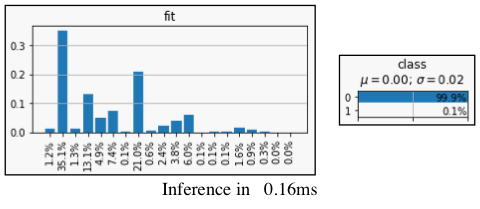

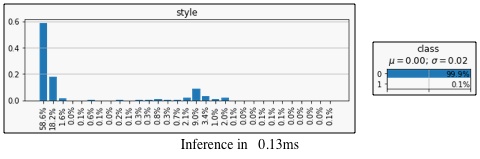

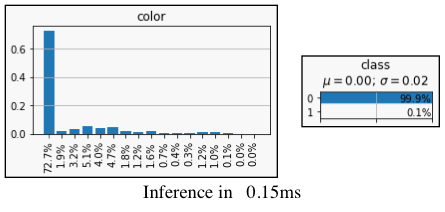

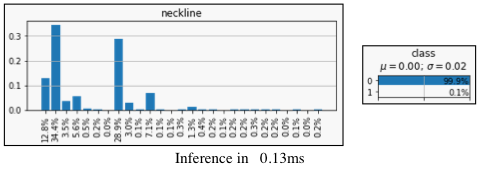

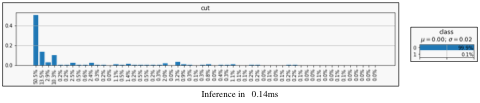

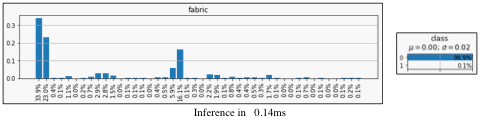

../data_docs/shirt#male#dress_code_active.csv
dress code size 474


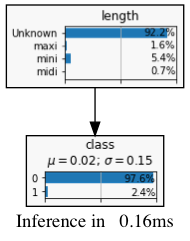

***** [0.9763436 0.0236564] [0.95406226 0.04593774] length maxi
0.8967826700306195 [-0.02308564  0.6636534 ]
thresh 0.8967826700306195
length maxi [0.95406226 0.04593774]
k [-0.02308564  0.6636534 ]
0.045937737281700836 [-0.00057318  0.02170816]
***** [0.9763436 0.0236564] [0.99347677 0.00652323] length mini
0.8967826700306195 [ 0.0173961 -1.2882636]
thresh 0.8967826700306195
length mini [0.99347677 0.00652323]
k [ 0.0173961 -1.2882636]
0.0065232318608377205 [-0.00057318 -0.01770635]
***** [0.9763436 0.0236564] [9.99151104e-01 8.48896435e-04] length midi
0.8967826700306195 [ 0.02309144 -3.32745163]
thresh 0.8967826700306195
length midi [9.99151104e-01 8.48896435e-04]
k [ 0.02309144 -3.32745163]
0.0008488964346349745 [-0.00057318 -0.02338068]


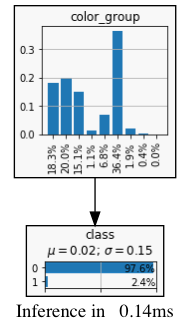

***** [0.9763436 0.0236564] [0.98250379 0.01749621] color_group dark
0.8967826700306195 [ 0.00628963 -0.30164946]
thresh 0.8967826700306195
color_group dark [0.98250379 0.01749621]
k [ 0.00628963 -0.30164946]
0.01749620637329287 [-0.00057318 -0.00673337]
***** [0.9763436 0.0236564] [0.98840415 0.01159585] color_group pale
0.8967826700306195 [ 0.01227709 -0.71298591]
thresh 0.8967826700306195
color_group pale [0.98840415 0.01159585]
k [ 0.01227709 -0.71298591]
0.011595854160541019 [-0.00057318 -0.01263373]
***** [0.9763436 0.0236564] [0.98206388 0.01793612] color_group cool_color
0.8967826700306195 [ 0.00584178 -0.2768171 ]
thresh 0.8967826700306195
color_group cool_color [0.98206388 0.01793612]
k [ 0.00584178 -0.2768171 ]
0.017936117936117938 [-0.00057318 -0.00629346]
***** [0.9763436 0.0236564] [0.9815783 0.0184217] color_group bright
0.8967826700306195 [ 0.00534721 -0.25010436]
thresh 0.8967826700306195
color_group bright [0.9815783 0.0184217]
k [ 0.00534721 -0.25010436]
0.0184216975

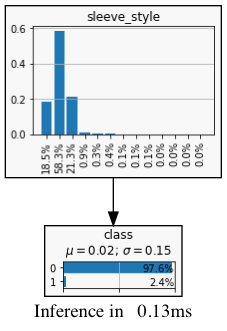

***** [0.9763436 0.0236564] [0.97521235 0.02478765] sleeve_style long_sleeve
0.8967826700306195 [-0.00115934  0.04671212]
thresh 0.8967826700306195
sleeve_style long_sleeve [0.97521235 0.02478765]
k [-0.00115934  0.04671212]
0.024787652786409778 [-0.00057318  0.00055807]
***** [0.9763436 0.0236564] [0.97024914 0.02975086] sleeve_style short_sleeve
0.8967826700306195 [-0.00626169  0.2292245 ]
thresh 0.8967826700306195
sleeve_style short_sleeve [0.97024914 0.02975086]
k [-0.00626169  0.2292245 ]
0.02975086018987227 [-0.00057318  0.00552128]
***** [0.9763436 0.0236564] [0.72244444 0.27755556] sleeve_style sleeveless
0.8967826700306195 [-0.30117405  2.46238757]
thresh 0.8967826700306195
sleeve_style sleeveless [0.72244444 0.27755556]
k [-0.30117405  2.46238757]
0.27755555555555556 [-0.00057318  0.25332597]
***** [0.9763436 0.0236564] [9.99348958e-01 6.51041667e-04] sleeve_style batwing
0.8967826700306195 [ 0.02328945 -3.59281518]
thresh 0.8967826700306195
sleeve_style batwing [9.99348958e-

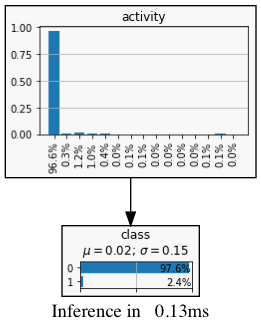

***** [0.9763436 0.0236564] [0.96922301 0.03077699] activity beach
0.8967826700306195 [-0.00731985  0.26313389]
thresh 0.8967826700306195
activity beach [0.96922301 0.03077699]
k [-0.00731985  0.26313389]
0.03077699293642785 [-0.00057318  0.00654741]
***** [0.9763436 0.0236564] [1.39431121e-04 9.99860569e-01] activity gym
0.8967826700306195 [-8.85399913  3.7439823 ]
thresh 0.8967826700306195
activity gym [1.39431121e-04 9.99860569e-01]
k [-8.85399913  3.7439823 ]
0.9998605688789738 [-5.73184575e-04  9.75630988e-01]
***** [0.9763436 0.0236564] [0.93284095 0.06715905] activity outdoor
0.8967826700306195 [-0.04557986  1.04343017]
thresh 0.8967826700306195
activity outdoor [0.93284095 0.06715905]
k [-0.04557986  1.04343017]
0.06715905187220886 [-0.00057318  0.04292947]
***** [0.9763436 0.0236564] [4.38212095e-04 9.99561788e-01] activity basketball
0.8967826700306195 [-7.70886683  3.74368343]
thresh 0.8967826700306195
activity basketball [4.38212095e-04 9.99561788e-01]
k [-7.70886683  3.743

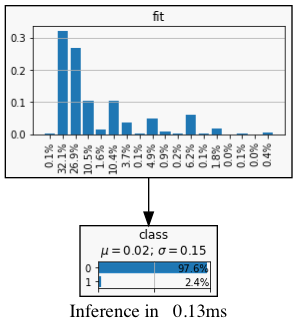

***** [0.9763436 0.0236564] [0.93598616 0.06401384] fit fitted
0.8967826700306195 [-0.04221389  0.99546578]
thresh 0.8967826700306195
fit fitted [0.93598616 0.06401384]
k [-0.04221389  0.99546578]
0.06401384083044982 [-0.00057318  0.03978426]
***** [0.9763436 0.0236564] [0.99564452 0.00435548] fit regular
0.8967826700306195 [ 0.01957571 -1.69219793]
thresh 0.8967826700306195
fit regular [0.99564452 0.00435548]
k [ 0.01957571 -1.69219793]
0.004355483419809896 [-0.00057318 -0.0198741 ]
***** [0.9763436 0.0236564] [9.99254675e-01 7.45325013e-04] fit slim
0.8967826700306195 [ 0.0231951  -3.45756844]
thresh 0.8967826700306195
fit slim [9.99254675e-01 7.45325013e-04]
k [ 0.0231951  -3.45756844]
0.00074532501310744 [-0.00057318 -0.02348426]
***** [0.9763436 0.0236564] [0.96157941 0.03842059] fit muscle_fit
0.8967826700306195 [-0.01523742  0.48495986]
thresh 0.8967826700306195
fit muscle_fit [0.96157941 0.03842059]
k [-0.01523742  0.48495986]
0.038420585625554574 [-0.00057318  0.014191  ]
****

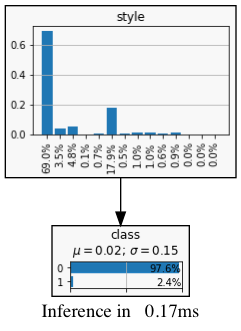

***** [0.9763436 0.0236564] [0.98278328 0.01721672] style goingout
0.8967826700306195 [ 0.00657405 -0.31775277]
thresh 0.8967826700306195
style goingout [0.98278328 0.01721672]
k [ 0.00657405 -0.31775277]
0.017216716051905587 [-0.00057318 -0.00701286]
***** [0.9763436 0.0236564] [0.90689859 0.09310141] style occasion
0.8967826700306195 [-0.07378394  1.3700558 ]
thresh 0.8967826700306195
style occasion [0.90689859 0.09310141]
k [-0.07378394  1.3700558 ]
0.09310141073934561 [-0.00057318  0.06887183]
***** [0.9763436 0.0236564] [0.40070922 0.59929078] style sexy
0.8967826700306195 [-0.89057855  3.23211338]
thresh 0.8967826700306195
style sexy [0.40070922 0.59929078]
k [-0.89057855  3.23211338]
0.599290780141844 [-5.73184575e-04  5.75061199e-01]
***** [0.9763436 0.0236564] [0.93267849 0.06732151] style retro
0.8967826700306195 [-0.04575404  1.04584632]
thresh 0.8967826700306195
style retro [0.93267849 0.06732151]
k [-0.04575404  1.04584632]
0.0673215141351222 [-0.00057318  0.04309193]
****

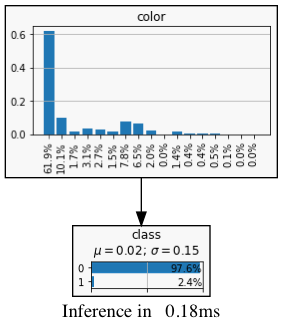

***** [0.9763436 0.0236564] [0.9825952 0.0174048] color pattern
0.8967826700306195 [ 0.00638266 -0.30688746]
thresh 0.8967826700306195
color pattern [0.9825952 0.0174048]
k [ 0.00638266 -0.30688746]
0.017404800834103454 [-0.00057318 -0.00682478]
***** [0.9763436 0.0236564] [0.98321242 0.01678758] color blue
0.8967826700306195 [ 0.00701061 -0.34299423]
thresh 0.8967826700306195
color blue [0.98321242 0.01678758]
k [ 0.00701061 -0.34299423]
0.016787579802669764 [-0.00057318 -0.007442  ]
***** [0.9763436 0.0236564] [0.98205846 0.01794154] color green
0.8967826700306195 [ 0.00583626 -0.27651502]
thresh 0.8967826700306195
color green [0.98205846 0.01794154]
k [ 0.00583626 -0.27651502]
0.017941536845790307 [-0.00057318 -0.00628804]
***** [0.9763436 0.0236564] [0.95019826 0.04980174] color gray
0.8967826700306195 [-0.02714392  0.74441632]
thresh 0.8967826700306195
color gray [0.95019826 0.04980174]
k [-0.02714392  0.74441632]
0.04980173716012085 [-0.00057318  0.02557216]
***** [0.9763436 0.02

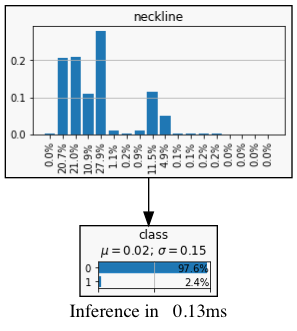

***** [0.9763436 0.0236564] [0.88650307 0.11349693] neckline crew_neck
0.8967826700306195 [-0.09652999  1.56814227]
thresh 0.8967826700306195
neckline crew_neck [0.88650307 0.11349693]
k [-0.09652999  1.56814227]
0.11349693251533742 [-0.00057318  0.08926735]
***** [0.9763436 0.0236564] [0.99854999 0.00145001] neckline button_collar
0.8967826700306195 [ 0.02248964 -2.79206215]
thresh 0.8967826700306195
neckline button_collar [0.99854999 0.00145001]
k [ 0.02248964 -2.79206215]
0.0014500113595359964 [-0.00057318 -0.02277957]
***** [0.9763436 0.0236564] [0.99288619 0.00711381] neckline point_collar
0.8967826700306195 [ 0.01680147 -1.20159589]
thresh 0.8967826700306195
neckline point_collar [0.99288619 0.00711381]
k [ 0.01680147 -1.20159589]
0.007113807762671265 [-0.00057318 -0.01711577]
***** [0.9763436 0.0236564] [0.97085696 0.02914304] neckline collar
0.8967826700306195 [-0.00563543  0.20858253]
thresh 0.8967826700306195
neckline collar [0.97085696 0.02914304]
k [-0.00563543  0.20858253]

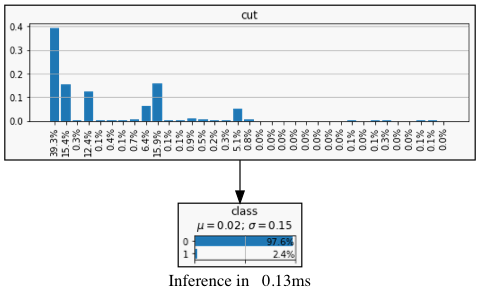

***** [0.9763436 0.0236564] [9.99346229e-01 6.53770540e-04] cut button
0.8967826700306197 [ 0.02328672 -3.58863239]
thresh 0.8967826700306197
cut button [9.99346229e-01 6.53770540e-04]
k [ 0.02328672 -3.58863239]
0.0006537705404503134 [-0.00057318 -0.02357581]
***** [0.9763436 0.0236564] [0.96404895 0.03595105] cut closecut
0.8967826700306197 [-0.0126725   0.41852462]
thresh 0.8967826700306197
cut closecut [0.96404895 0.03595105]
k [-0.0126725   0.41852462]
0.03595104538500765 [-0.00057318  0.01172146]
***** [0.9763436 0.0236564] [0.99638999 0.00361001] cut button_down
0.8967826700306197 [ 0.02032416 -1.87992437]
thresh 0.8967826700306197
cut button_down [0.99638999 0.00361001]
k [ 0.02032416 -1.87992437]
0.0036100050345553576 [-0.00057318 -0.02061958]
***** [0.9763436 0.0236564] [0.54539559 0.45460441] cut laceup
0.8967826700306197 [-0.58230319  2.95579407]
thresh 0.8967826700306197
cut laceup [0.54539559 0.45460441]
k [-0.58230319  2.95579407]
0.45460440985732814 [-0.00057318  0.4303

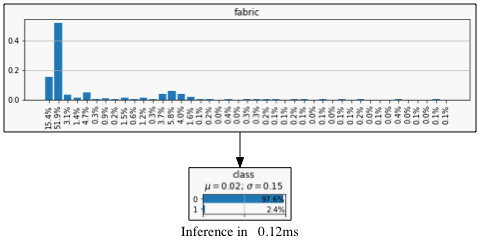

***** [0.9763436 0.0236564] [0.96142278 0.03857722] fabric cotton
0.8967826700306196 [-0.01540033  0.48902846]
thresh 0.8967826700306196
fabric cotton [0.96142278 0.03857722]
k [-0.01540033  0.48902846]
0.03857722228922929 [-0.00057318  0.01434764]
***** [0.9763436 0.0236564] [0.98084341 0.01915659] fabric flannel
0.8967826700306196 [ 0.00459825 -0.21098672]
thresh 0.8967826700306196
fabric flannel [0.98084341 0.01915659]
k [ 0.00459825 -0.21098672]
0.019156590757362212 [-0.00057318 -0.00507299]
***** [0.9763436 0.0236564] [0.93498153 0.06501847] fabric jersey
0.8967826700306196 [-0.0432878   1.01103782]
thresh 0.8967826700306196
fabric jersey [0.93498153 0.06501847]
k [-0.0432878   1.01103782]
0.06501846877098724 [-0.00057318  0.04078889]
***** [0.9763436 0.0236564] [0.86751224 0.13248776] fabric polyester
0.8967826700306196 [-0.11818496  1.72285675]
thresh 0.8967826700306196
fabric polyester [0.86751224 0.13248776]
k [-0.11818496  1.72285675]
0.13248776367114712 [-0.00057318  0.10825

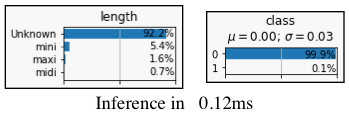

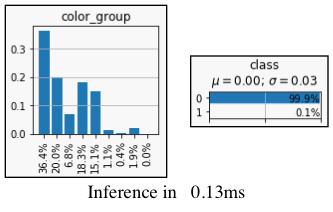

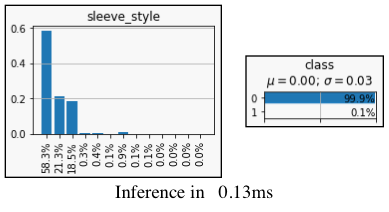

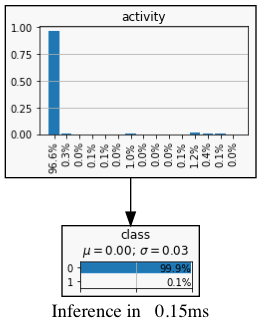

***** [9.99177386e-01 8.22614418e-04] [0.9086781 0.0913219] activity beach
0.9962188870847841 [-0.09494142  4.70965829]
thresh 0.9962188870847841
activity beach [0.9086781 0.0913219]
k [-0.09494142  4.70965829]
0.09132189707366296 [-6.77251598e-07  9.04986054e-02]
***** [9.99177386e-01 8.22614418e-04] [0.99450549 0.00549451] activity city
0.9962188870847841 [-0.0046867   1.89901629]
thresh 0.9962188870847841
activity city [0.99450549 0.00549451]
k [-0.0046867   1.89901629]
0.005494505494505495 [-6.77251598e-07  4.67121382e-03]
***** [9.99177386e-01 8.22614418e-04] [0.99778761 0.00221239] activity skateboarding
0.9962188870847841 [-0.00139189  0.98934079]
thresh 0.9962188870847841
activity skateboarding [0.99778761 0.00221239]
k [-0.00139189  0.98934079]
0.0022123893805309734 [-6.77251598e-07  1.38909771e-03]
***** [9.99177386e-01 8.22614418e-04] [0.99841772 0.00158228] activity jungle
0.9962188870847841 [-0.00076058  0.65413358]
thresh 0.9962188870847841
activity jungle [0.99841772 0.0

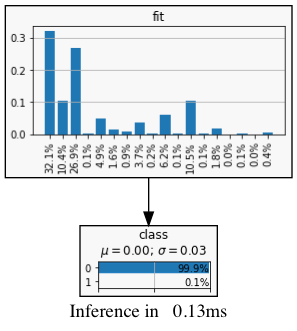

***** [9.99177386e-01 8.22614418e-04] [0.9975093 0.0024907] fit regular
0.9962188870847841 [-0.00167085  1.10783055]
thresh 0.9962188870847841
fit regular [0.9975093 0.0024907]
k [-0.00167085  1.10783055]
0.002490697654341239 [-6.77251598e-07  1.66740598e-03]
***** [9.99177386e-01 8.22614418e-04] [9.99986626e-01 1.33736325e-05] fit skinny
0.9962188870847841 [ 8.09579229e-04 -4.11920254e+00]
thresh 0.9962188870847841
fit skinny [9.99986626e-01 1.33736325e-05]
k [ 8.09579229e-04 -4.11920254e+00]
1.3373632546072162e-05 [-6.77251598e-07 -8.09918037e-04]
***** [9.99177386e-01 8.22614418e-04] [9.9999486e-01 5.1401725e-06] fit slim
0.9962188870847841 [ 8.17812765e-04 -5.07540094e+00]
thresh 0.9962188870847841
fit slim [9.9999486e-01 5.1401725e-06]
k [ 8.17812765e-04 -5.07540094e+00]
5.140172504189241e-06 [-6.77251598e-07 -8.18151497e-04]
***** [9.99177386e-01 8.22614418e-04] [9.99009901e-01 9.90099010e-04] fit super_skinny
0.9962188870847841 [-1.67636531e-04  1.85317365e-01]
thresh 0.99621888

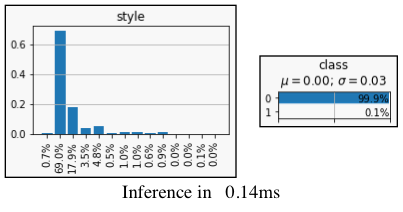

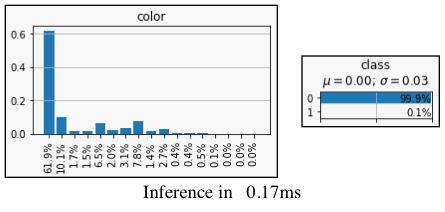

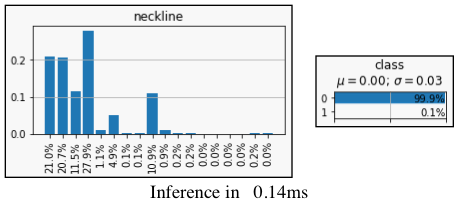

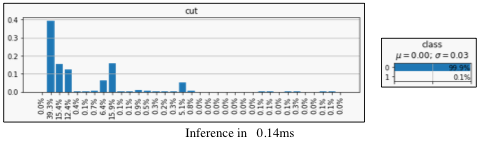

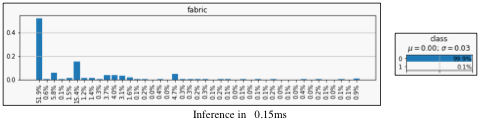

../data_docs/shirt#male#dress_code_black tie.csv
dress code size 14


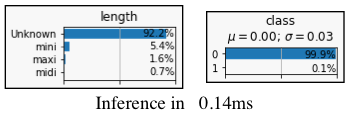

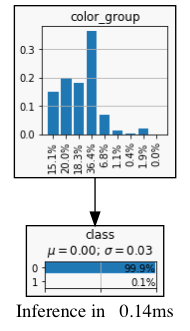

***** [9.99277096e-01 7.22903580e-04] [0.9960122 0.0039878] color_group pale
0.9966764412770619 [-0.00327261  1.70771855]
thresh 0.9966764412770619
color_group pale [0.9960122 0.0039878]
k [-0.00327261  1.70771855]
0.003987797706556895 [-5.22967641e-07  3.26437116e-03]
***** [9.99277096e-01 7.22903580e-04] [9.99984825e-01 1.51745068e-05] color_group dark
0.9966764412770619 [ 7.07990378e-04 -3.86365901e+00]
thresh 0.9966764412770619
color_group dark [9.99984825e-01 1.51745068e-05]
k [ 7.07990378e-04 -3.86365901e+00]
1.517450682852807e-05 [-5.22967641e-07 -7.08252040e-04]
***** [9.99277096e-01 7.22903580e-04] [9.99992395e-01 7.60502540e-06] color_group pattern
0.9966764412770619 [ 7.15559946e-04 -4.55446659e+00]
thresh 0.9966764412770619
color_group pattern [9.99992395e-01 7.60502540e-06]
k [ 7.15559946e-04 -4.55446659e+00]
7.605025400784838e-06 [-5.22967641e-07 -7.15821522e-04]
***** [9.99277096e-01 7.22903580e-04] [9.99959154e-01 4.08463361e-05] color_group bright
0.9966764412770619 [ 

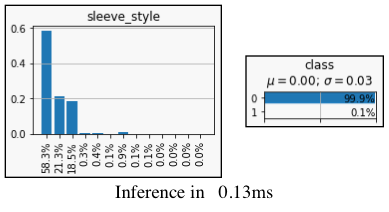

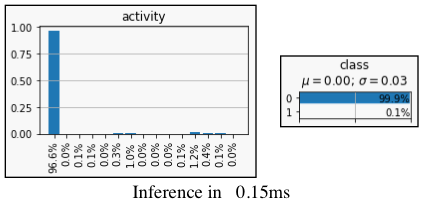

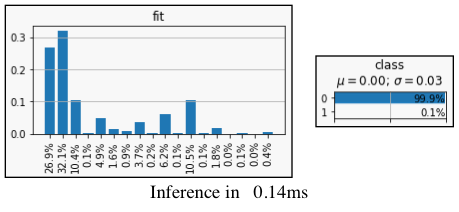

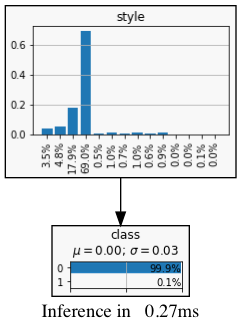

***** [9.99277096e-01 7.22903580e-04] [0.9913661 0.0086339] style goingout
0.9966764412770619 [-0.00794823  2.48017599]
thresh 0.9966764412770619
style goingout [0.9913661 0.0086339]
k [-0.00794823  2.48017599]
0.008633902115050576 [-5.22967641e-07  7.91047557e-03]
***** [9.99277096e-01 7.22903580e-04] [0.99582687 0.00417313] style occasion
0.9966764412770619 [-0.0034587   1.75314566]
thresh 0.9966764412770619
style occasion [0.99582687 0.00417313]
k [-0.0034587   1.75314566]
0.00417312947780486 [-5.22967641e-07  3.44970293e-03]
***** [9.99277096e-01 7.22903580e-04] [0.99887649 0.00112351] style classic
0.9966764412770619 [-4.0097274e-04  4.4093370e-01]
thresh 0.9966764412770619
style classic [0.99887649 0.00112351]
k [-4.0097274e-04  4.4093370e-01]
0.0011235061345423452 [-5.22967641e-07  4.00079587e-04]
***** [9.99277096e-01 7.22903580e-04] [9.99607843e-01 3.92156863e-04] style fancy
0.9966764412770619 [ 3.30931224e-04 -6.11613932e-01]
thresh 0.9966764412770619
style fancy [9.99607843

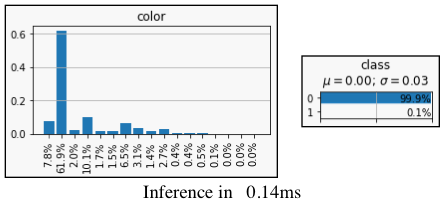

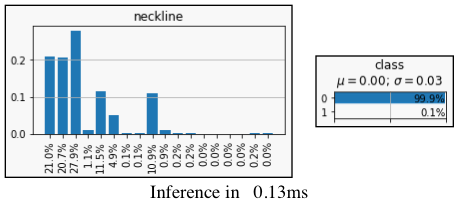

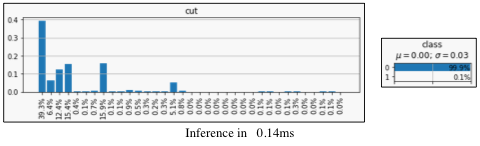

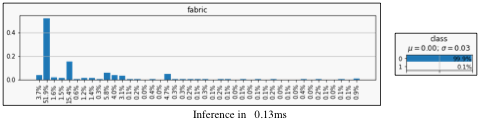

../data_docs/shirt#male#dress_code_business formal.csv
dress code size 281


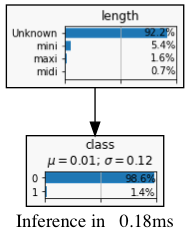

***** [0.9859657 0.0140343] [0.89826047 0.10173953] length mini
0.9374139215419844 [-0.09316148  1.98091153]
thresh 0.9374139215419844
length mini [0.89826047 0.10173953]
k [-0.09316148  1.98091153]
0.10173952849622339 [-0.00019977  0.08750546]
***** [0.9859657 0.0140343] [0.96924829 0.03075171] length maxi
0.9374139215419844 [-0.01710075  0.78444118]
thresh 0.9374139215419844
length maxi [0.96924829 0.03075171]
k [-0.01710075  0.78444118]
0.030751708428246014 [-0.00019977  0.01651764]
***** [0.9859657 0.0140343] [9.99151104e-01 8.48896435e-04] length midi
0.9374139215419844 [ 0.01328446 -2.80532246]
thresh 0.9374139215419844
length midi [9.99151104e-01 8.48896435e-04]
k [ 0.01328446 -2.80532246]
0.0008488964346349745 [-0.00019977 -0.01338517]


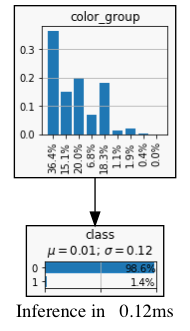

***** [0.9859657 0.0140343] [0.99410611 0.00589389] color_group pattern
0.9374139215419844 [ 0.00822238 -0.86758735]
thresh 0.9374139215419844
color_group pattern [0.99410611 0.00589389]
k [ 0.00822238 -0.86758735]
0.00589389468560825 [-0.00019977 -0.00834017]
***** [0.9859657 0.0140343] [0.96988018 0.03011982] color_group pale
0.9374139215419844 [-0.01644903  0.76367898]
thresh 0.9374139215419844
color_group pale [0.96988018 0.03011982]
k [-0.01644903  0.76367898]
0.03011981770067627 [-0.00019977  0.01588575]
***** [0.9859657 0.0140343] [0.9771669 0.0228331] color_group bright
0.9374139215419844 [-0.0089641   0.48670695]
thresh 0.9374139215419844
color_group bright [0.9771669 0.0228331]
k [-0.0089641   0.48670695]
0.022833101870762193 [-0.00019977  0.00859904]
***** [0.9859657 0.0140343] [0.99424886 0.00575114] color_group dark
0.9374139215419844 [ 0.00836597 -0.89210661]
thresh 0.9374139215419844
color_group dark [0.99424886 0.00575114]
k [ 0.00836597 -0.89210661]
0.00575113808801214

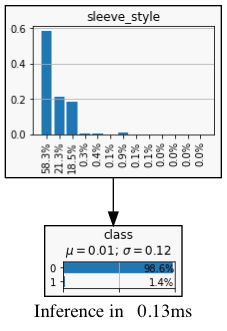

***** [0.9859657 0.0140343] [0.97259102 0.02740898] sleeve_style short_sleeve
0.9374139215419844 [-0.0136579  0.6693664]
thresh 0.9374139215419844
sleeve_style short_sleeve [0.97259102 0.02740898]
k [-0.0136579  0.6693664]
0.02740898200356686 [-0.00019977  0.01317492]
***** [0.9859657 0.0140343] [0.99675782 0.00324218] sleeve_style long_sleeve
0.9374139215419844 [ 0.01088627 -1.46525861]
thresh 0.9374139215419844
sleeve_style long_sleeve [0.99675782 0.00324218]
k [ 0.01088627 -1.46525861]
0.003242179407499482 [-0.00019977 -0.01099189]
***** [0.9859657 0.0140343] [9.99348958e-01 6.51041667e-04] sleeve_style batwing
0.9374139215419844 [ 0.01348246 -3.07068601]
thresh 0.9374139215419844
sleeve_style batwing [9.99348958e-01 6.51041667e-04]
k [ 0.01348246 -3.07068601]
0.0006510416666666667 [-0.00019977 -0.01358302]
***** [0.9859657 0.0140343] [9.99537037e-01 4.62962963e-04] sleeve_style drop_shoulder
0.9374139215419844 [ 0.01367064 -3.41161259]
thresh 0.9374139215419844
sleeve_style drop_sh

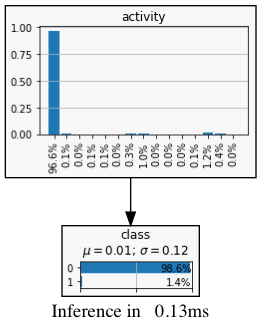

***** [0.9859657 0.0140343] [0.00110865 0.99889135] activity run
0.9374139215419844 [-6.79048081  4.26514165]
thresh 0.9374139215419844
activity run [0.00110865 0.99889135]
k [-6.79048081  4.26514165]
0.9988913525498891 [-1.99765156e-04  9.84657287e-01]
***** [0.9859657 0.0140343] [0.99450549 0.00549451] activity city
0.9374139215419844 [ 0.00862406 -0.93775578]
thresh 0.9374139215419844
activity city [0.99450549 0.00549451]
k [ 0.00862406 -0.93775578]
0.005494505494505495 [-0.00019977 -0.00873956]
***** [0.9859657 0.0140343] [0.99778761 0.00221239] activity skateboarding
0.9374139215419844 [ 0.01191887 -1.84743127]
thresh 0.9374139215419844
activity skateboarding [0.99778761 0.00221239]
k [ 0.01191887 -1.84743127]
0.0022123893805309734 [-0.00019977 -0.01202168]
***** [0.9859657 0.0140343] [0.99841772 0.00158228] activity jungle
0.9374139215419844 [ 0.01255018 -2.18263849]
thresh 0.9374139215419844
activity jungle [0.99841772 0.00158228]
k [ 0.01255018 -2.18263849]
0.001582278481012658

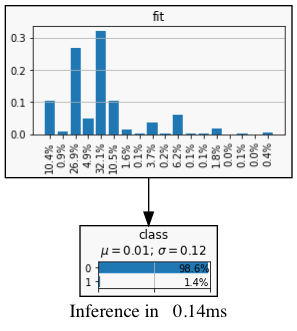

***** [0.9859657 0.0140343] [0.99517212 0.00482788] fit skinny
0.9374139215419846 [ 0.00929414 -1.06709664]
thresh 0.9374139215419846
fit skinny [0.99517212 0.00482788]
k [ 0.00929414 -1.06709664]
0.004827881349132051 [-0.00019977 -0.00940618]
***** [0.9859657 0.0140343] [0.17623856 0.82376144] fit tailored
0.9374139215419846 [-1.72178303  4.0723766 ]
thresh 0.9374139215419846
fit tailored [0.17623856 0.82376144]
k [-1.72178303  4.0723766 ]
0.8237614389397286 [-1.99765156e-04  8.09527373e-01]
***** [0.9859657 0.0140343] [0.98926218 0.01073782] fit slim
0.9374139215419846 [ 0.00333783 -0.26773225]
thresh 0.9374139215419846
fit slim [0.98926218 0.01073782]
k [ 0.00333783 -0.26773225]
0.010737820361251324 [-0.00019977 -0.00349625]
***** [0.9859657 0.0140343] [0.99793517 0.00206483] fit regular_fit
0.9374139215419846 [ 0.01206675 -1.91645647]
thresh 0.9374139215419846
fit regular_fit [0.99793517 0.00206483]
k [ 0.01206675 -1.91645647]
0.0020648300050913615 [-0.00019977 -0.01216924]
***** [

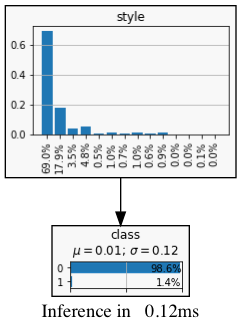

***** [0.9859657 0.0140343] [0.96018016 0.03981984] style classic
0.9374139215419844 [-0.02650063  1.04286094]
thresh 0.9374139215419844
style classic [0.96018016 0.03981984]
k [-0.02650063  1.04286094]
0.03981984131718666 [-0.00019977  0.02558578]
***** [0.9859657 0.0140343] [0.98850516 0.01149484] style goingout
0.9374139215419844 [ 0.0025723  -0.19960612]
thresh 0.9374139215419844
style goingout [0.98850516 0.01149484]
k [ 0.0025723  -0.19960612]
0.01149484009400225 [-0.00019977 -0.00273923]
***** [0.9859657 0.0140343] [9.99963070e-01 3.69303494e-05] style occasion
0.9374139215419844 [ 0.01409678 -5.94022596]
thresh 0.9374139215419844
style occasion [9.99963070e-01 3.69303494e-05]
k [ 0.01409678 -5.94022596]
3.6930349361104953e-05 [-0.00019977 -0.01419714]
***** [0.9859657 0.0140343] [9.99607843e-01 3.92156863e-04] style fancy
0.9374139215419844 [ 0.01374148 -3.57759773]
thresh 0.9374139215419844
style fancy [9.99607843e-01 3.92156863e-04]
k [ 0.01374148 -3.57759773]
0.0003921568627

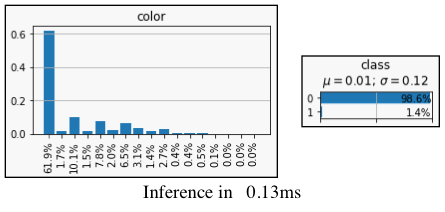

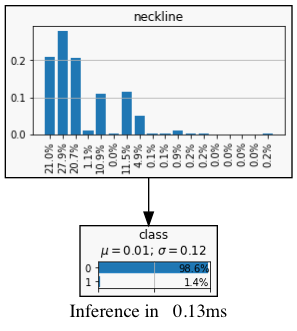

***** [0.9859657 0.0140343] [0.99288619 0.00711381] neckline point_collar
0.9374139215419846 [ 0.00699448 -0.67946672]
thresh 0.9374139215419846
neckline point_collar [0.99288619 0.00711381]
k [ 0.00699448 -0.67946672]
0.007113807762671265 [-0.00019977 -0.00712026]
***** [0.9859657 0.0140343] [0.96388528 0.03611472] neckline collar
0.9374139215419846 [-0.02264929  0.9451963 ]
thresh 0.9374139215419846
neckline collar [0.96388528 0.03611472]
k [-0.02264929  0.9451963 ]
0.03611472495605455 [-0.00019977  0.02188066]
***** [0.9859657 0.0140343] [9.99031098e-01 9.68901600e-04] neckline button_collar
0.9374139215419846 [ 0.01316434 -2.67309659]
thresh 0.9374139215419846
neckline button_collar [9.99031098e-01 9.68901600e-04]
k [ 0.01316434 -2.67309659]
0.0009689015996899515 [-0.00019977 -0.01326516]
***** [0.9859657 0.0140343] [0.97273184 0.02726816] neckline v_neck
0.9374139215419846 [-0.01351312  0.66421527]
thresh 0.9374139215419846
neckline v_neck [0.97273184 0.02726816]
k [-0.01351312  0

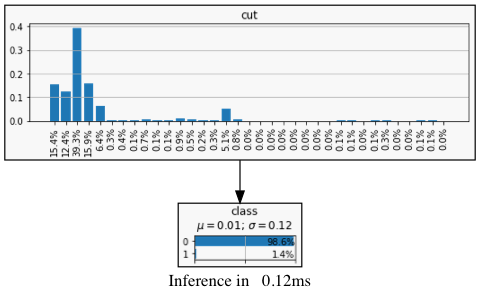

***** [0.9859657 0.0140343] [0.99090749 0.00909251] cut button
0.9374139215419844 [ 0.00499961 -0.43405328]
thresh 0.9374139215419844
cut button [0.99090749 0.00909251]
k [ 0.00499961 -0.43405328]
0.00909251084980897 [-0.00019977 -0.00514155]
***** [0.9859657 0.0140343] [0.96074763 0.03925237] cut button_down
0.9374139215419844 [-0.0259098   1.02850742]
thresh 0.9374139215419844
cut button_down [0.96074763 0.03925237]
k [-0.0259098   1.02850742]
0.03925236852945216 [-0.00019977  0.0250183 ]
***** [0.9859657 0.0140343] [0.98683362 0.01316638] cut pocket
0.9374139215419844 [ 0.00087989 -0.06383798]
thresh 0.9374139215419844
cut pocket [0.98683362 0.01316638]
k [ 0.00087989 -0.06383798]
0.013166377164550616 [-0.00019977 -0.00106769]
***** [0.9859657 0.0140343] [0.99842637 0.00157363] cut narrow
0.9374139215419844 [ 0.01255885 -2.18812212]
thresh 0.9374139215419844
cut narrow [0.99842637 0.00157363]
k [ 0.01255885 -2.18812212]
0.0015736255887145376 [-0.00019977 -0.01266044]
***** [0.985965

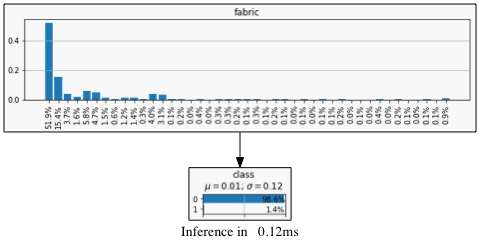

***** [0.9859657 0.0140343] [0.93549104 0.06450896] fabric cotton
0.9374139215419846 [-0.05254999  1.52529969]
thresh 0.9374139215419846
fabric cotton [0.93549104 0.06450896]
k [-0.05254999  1.52529969]
0.06450895549390906 [-0.00019977  0.05027489]
***** [0.9859657 0.0140343] [0.97868025 0.02131975] fabric poplin
0.9374139215419846 [-0.00741659  0.41812949]
thresh 0.9374139215419846
fabric poplin [0.97868025 0.02131975]
k [-0.00741659  0.41812949]
0.02131974979872422 [-0.00019977  0.00708568]
***** [0.9859657 0.0140343] [0.98777029 0.01222971] fabric twill
0.9374139215419846 [ 0.00182861 -0.13763648]
thresh 0.9374139215419846
fabric twill [0.98777029 0.01222971]
k [ 0.00182861 -0.13763648]
0.012229705778092875 [-0.00019977 -0.00200436]
***** [0.9859657 0.0140343] [0.99826886 0.00173114] fabric denim
0.9374139215419846 [ 0.01240107 -2.09272274]
thresh 0.9374139215419846
fabric denim [0.99826886 0.00173114]
k [ 0.01240107 -2.09272274]
0.0017311425540856961 [-0.00019977 -0.01250292]
*****

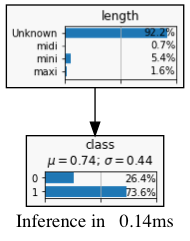

***** [0.26425865 0.73574135] [0.01443124 0.98556876] length midi
0.03376893000017399 [-2.9075331   0.29234027]
thresh 0.03376893000017399
length midi [0.01443124 0.98556876]
k [-2.9075331   0.29234027]
0.9855687606112055 [-2.04842995 -1.79860254]
***** [0.26425865 0.73574135] [0.17498283 0.82501717] length mini
0.03376893000017399 [-0.41224048  0.11452556]
thresh 0.03376893000017399
length mini [0.17498283 0.82501717]
k [-0.41224048  0.11452556]
0.8250171663996337 [-2.04842995 -1.95915414]
***** [0.26425865 0.73574135] [0.27980258 0.72019742] length maxi
0.03376893000017399 [ 0.05715593 -0.02135326]
thresh 0.03376893000017399
length maxi [0.27980258 0.72019742]
k [ 0.05715593 -0.02135326]
0.7201974183750949 [-2.04842995 -2.06397389]


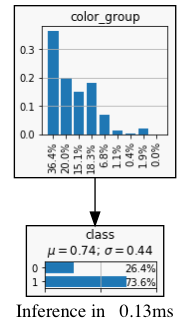

***** [0.26425865 0.73574135] [0.20712287 0.79287713] color_group pattern
0.03376893000017397 [-0.24361618  0.07478964]
thresh 0.03376893000017397
color_group pattern [0.20712287 0.79287713]
k [-0.24361618  0.07478964]
0.7928771332096249 [-2.04842995 -1.99129417]
***** [0.26425865 0.73574135] [0.39199868 0.60800132] color_group pale
0.03376893000017397 [ 0.39433011 -0.19070157]
thresh 0.03376893000017397
color_group pale [0.39199868 0.60800132]
k [ 0.39433011 -0.19070157]
0.6080013231402529 [-2.04842995 -2.17616998]
***** [0.26425865 0.73574135] [0.26578149 0.73421851] color_group dark
0.03376893000017397 [ 0.00574614 -0.00207194]
thresh 0.03376893000017397
color_group dark [0.26578149 0.73421851]
k [ 0.00574614 -0.00207194]
0.7342185128983308 [-2.04842995 -2.04995279]
***** [0.26425865 0.73574135] [0.30148681 0.69851319] color_group bright
0.03376893000017397 [ 0.1317979  -0.05192456]
thresh 0.03376893000017397
color_group bright [0.30148681 0.69851319]
k [ 0.1317979  -0.05192456]
0.6

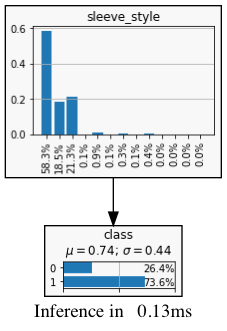

***** [0.26425865 0.73574135] [0.29464471 0.70535529] sleeve_style long_sleeve
0.03376893000017399 [ 0.10884189 -0.04217699]
thresh 0.03376893000017399
sleeve_style long_sleeve [0.29464471 0.70535529]
k [ 0.10884189 -0.04217699]
0.7053552931427388 [-2.04842995 -2.07881601]
***** [0.26425865 0.73574135] [0.16440886 0.83559114] sleeve_style short_sleeve
0.03376893000017399 [-0.47457201  0.1272608 ]
thresh 0.03376893000017399
sleeve_style short_sleeve [0.16440886 0.83559114]
k [-0.47457201  0.1272608 ]
0.8355911440975663 [-2.04842995 -1.94858016]
***** [0.26425865 0.73574135] [0.00159744 0.99840256] sleeve_style contrastsleeve
0.03376893000017399 [-5.10852345  0.30527793]
thresh 0.03376893000017399
sleeve_style contrastsleeve [0.00159744 0.99840256]
k [-5.10852345  0.30527793]
0.9984025559105432 [-2.04842995 -1.78576875]
***** [0.26425865 0.73574135] [0.27755556 0.72244444] sleeve_style sleeveless
0.03376893000017399 [ 0.04909276 -0.01823811]
thresh 0.03376893000017399
sleeve_style sleeve

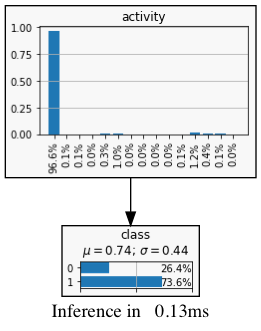

***** [0.26425865 0.73574135] [0.00221239 0.99778761] activity skateboarding
0.03376893000017399 [-4.78285526  0.30466181]
thresh 0.03376893000017399
activity skateboarding [0.00221239 0.99778761]
k [-4.78285526  0.30466181]
0.9977876106194691 [-2.04842995 -1.78638369]
***** [0.26425865 0.73574135] [0.00158228 0.99841772] activity jungle
0.03376893000017399 [-5.11806247  0.30529312]
thresh 0.03376893000017399
activity jungle [0.00158228 0.99841772]
k [-5.11806247  0.30529312]
0.9984177215189874 [-2.04842995 -1.78575358]
***** [0.26425865 0.73574135] [0.00549451 0.99450549] activity mountain
0.03376893000017399 [-3.87317977  0.30136699]
thresh 0.03376893000017399
activity mountain [0.00549451 0.99450549]
k [-3.87317977  0.30136699]
0.9945054945054945 [-2.04842995 -1.78966581]
***** [0.26425865 0.73574135] [0.12159435 0.87840565] activity beach
0.03376893000017399 [-0.77623786  0.17722987]
thresh 0.03376893000017399
activity beach [0.12159435 0.87840565]
k [-0.77623786  0.17722987]
0.878

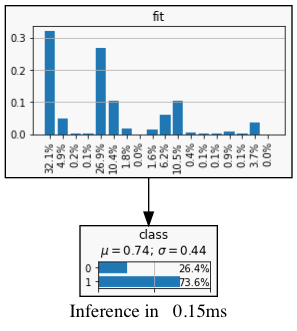

***** [0.26425865 0.73574135] [0.10256753 0.89743247] fit regular
0.03376893000017399 [-0.94640691  0.19865924]
thresh 0.03376893000017399
fit regular [0.10256753 0.89743247]
k [-0.94640691  0.19865924]
0.8974324662655075 [-2.04842995 -1.88673884]
***** [0.26425865 0.73574135] [0.03872263 0.96127737] fit regular_fit
0.03376893000017399 [-1.92050407  0.26738436]
thresh 0.03376893000017399
fit regular_fit [0.03872263 0.96127737]
k [-1.92050407  0.26738436]
0.9612773660689031 [-2.04842995 -1.82289394]
***** [0.26425865 0.73574135] [0.04219653 0.95780347] fit long_line
0.03376893000017399 [-1.83459033  0.26376398]
thresh 0.03376893000017399
fit long_line [0.04219653 0.95780347]
k [-1.83459033  0.26376398]
0.9578034682080925 [-2.04842995 -1.82636784]
***** [0.26425865 0.73574135] [0.14379947 0.85620053] fit musclefit
0.03376893000017399 [-0.60850858  0.15162598]
thresh 0.03376893000017399
fit musclefit [0.14379947 0.85620053]
k [-0.60850858  0.15162598]
0.8562005277044855 [-2.04842995 -1.92

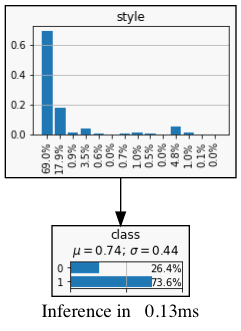

***** [0.26425865 0.73574135] [0.3499473 0.6500527] style classic
0.03376893000017397 [ 0.28085423 -0.1238252 ]
thresh 0.03376893000017397
style classic [0.3499473 0.6500527]
k [ 0.28085423 -0.1238252 ]
0.6500526954204697 [-2.04842995 -2.13411861]
***** [0.26425865 0.73574135] [1.96155355e-04 9.99803845e-01] style vintage
0.03376893000017397 [-7.20577666  0.30668047]
thresh 0.03376893000017397
style vintage [1.96155355e-04 9.99803845e-01]
k [-7.20577666  0.30668047]
0.9998038446449589 [-2.04842995 -1.78436746]
***** [0.26425865 0.73574135] [0.70241136 0.29758864] style goingout
0.03376893000017397 [ 0.97759086 -0.90516651]
thresh 0.03376893000017397
style goingout [0.70241136 0.29758864]
k [ 0.97759086 -0.90516651]
0.2975886379891693 [-2.04842995 -2.48658267]
***** [0.26425865 0.73574135] [0.02733119 0.97266881] style color_block
0.03376893000017397 [-2.26889983  0.27916501]
thresh 0.03376893000017397
style color_block [0.02733119 0.97266881]
k [-2.26889983  0.27916501]
0.9726688102893

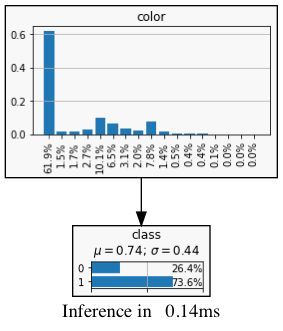

***** [0.26425865 0.73574135] [0.21753276 0.78246724] color pattern
0.03376893000017397 [-0.1945789   0.06157343]
thresh 0.03376893000017397
color pattern [0.21753276 0.78246724]
k [-0.1945789   0.06157343]
0.7824672401127936 [-2.04842995 -2.00170406]
***** [0.26425865 0.73574135] [0.18436371 0.81563629] color brown
0.03376893000017397 [-0.36001787  0.1030899 ]
thresh 0.03376893000017397
color brown [0.18436371 0.81563629]
k [-0.36001787  0.1030899 ]
0.8156362906463268 [-2.04842995 -1.96853501]
***** [0.26425865 0.73574135] [0.20243305 0.79756695] color green
0.03376893000017397 [-0.26651916  0.08068715]
thresh 0.03376893000017397
color green [0.20243305 0.79756695]
k [-0.26651916  0.08068715]
0.797566952564327 [-2.04842995 -1.98660435]
***** [0.26425865 0.73574135] [0.29699652 0.70300348] color blue
0.03376893000017397 [ 0.11679206 -0.04551679]
thresh 0.03376893000017397
color blue [0.29699652 0.70300348]
k [ 0.11679206 -0.04551679]
0.7030034822983169 [-2.04842995 -2.08116782]
***** [

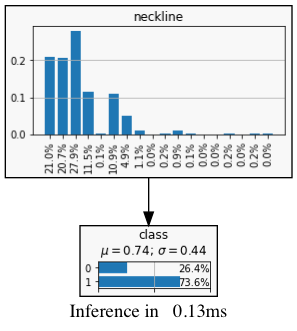

***** [0.26425865 0.73574135] [0.28311112 0.71688888] neckline point_collar
0.03376893000017399 [ 0.06891112 -0.02595778]
thresh 0.03376893000017399
neckline point_collar [0.28311112 0.71688888]
k [ 0.06891112 -0.02595778]
0.7168888771897498 [-2.04842995 -2.06728243]
***** [0.26425865 0.73574135] [0.21987384 0.78012616] neckline button_collar
0.03376893000017399 [-0.18387442  0.05857702]
thresh 0.03376893000017399
neckline button_collar [0.21987384 0.78012616]
k [-0.18387442  0.05857702]
0.7801261576703596 [-2.04842995 -2.00404515]
***** [0.26425865 0.73574135] [0.28459277 0.71540723] neckline collar
0.03376893000017399 [ 0.07413093 -0.0280267 ]
thresh 0.03376893000017399
neckline collar [0.28459277 0.71540723]
k [ 0.07413093 -0.0280267 ]
0.7154072279105796 [-2.04842995 -2.06876408]
***** [0.26425865 0.73574135] [0.02610976 0.97389024] neckline reverecollar
0.03376893000017399 [-2.31461935  0.28041998]
thresh 0.03376893000017399
neckline reverecollar [0.02610976 0.97389024]
k [-2.31461

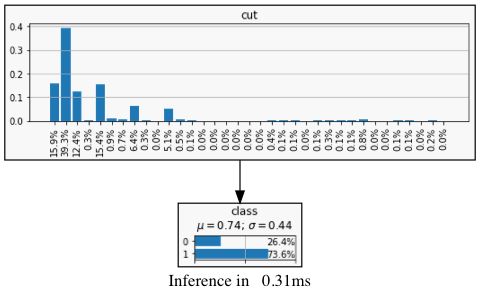

***** [0.26425865 0.73574135] [0.23315814 0.76684186] cut pocket
0.03376893000017393 [-0.12521142  0.04140197]
thresh 0.03376893000017393
cut pocket [0.23315814 0.76684186]
k [-0.12521142  0.04140197]
0.7668418602152463 [-2.04842995 -2.01732944]
***** [0.26425865 0.73574135] [0.16500183 0.83499817] cut button_down
0.03376893000017393 [-0.47097179  0.1265509 ]
thresh 0.03376893000017393
cut button_down [0.16500183 0.83499817]
k [-0.47097179  0.1265509 ]
0.8349981692525974 [-2.04842995 -1.94917314]
***** [0.26425865 0.73574135] [0.21443141 0.78556859] cut closecut
0.03376893000017393 [-0.20893843  0.06552914]
thresh 0.03376893000017393
cut closecut [0.21443141 0.78556859]
k [-0.20893843  0.06552914]
0.7855685874553799 [-2.04842995 -1.99860272]
***** [0.26425865 0.73574135] [0.26777236 0.73222764] cut button
0.03376893000017393 [ 0.01320885 -0.00478718]
thresh 0.03376893000017393
cut button [0.26777236 0.73222764]
k [ 0.01320885 -0.00478718]
0.7322276419748507 [-2.04842995 -2.05194366]
**

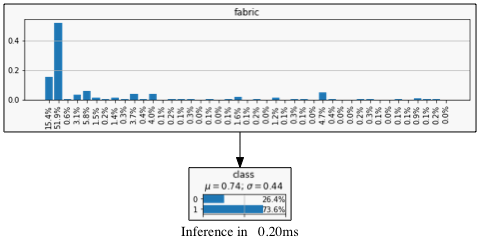

***** [0.26425865 0.73574135] [0.38638659 0.61361341] fabric cotton
0.03376893000017399 [ 0.37991005 -0.18151353]
thresh 0.03376893000017399
fabric cotton [0.38638659 0.61361341]
k [ 0.37991005 -0.18151353]
0.6136134061030033 [-2.04842995 -2.1705579 ]
***** [0.26425865 0.73574135] [0.53981481 0.46018519] fabric wovencotton
0.03376893000017399 [ 0.71429779 -0.46924965]
thresh 0.03376893000017399
fabric wovencotton [0.53981481 0.46018519]
k [ 0.71429779 -0.46924965]
0.4601851851851852 [-2.04842995 -2.32398612]
***** [0.26425865 0.73574135] [0.69058304 0.30941696] fabric flannel
0.03376893000017399 [ 0.96060787 -0.86618889]
thresh 0.03376893000017399
fabric flannel [0.69058304 0.30941696]
k [ 0.96060787 -0.86618889]
0.30941695719902085 [-2.04842995 -2.47475435]
***** [0.26425865 0.73574135] [0.05336522 0.94663478] fabric denim
0.03376893000017399 [-1.59976912  0.25203473]
thresh 0.03376893000017399
fabric denim [0.05336522 0.94663478]
k [-1.59976912  0.25203473]
0.9466347789541096 [-2.048

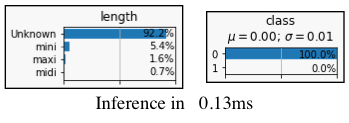

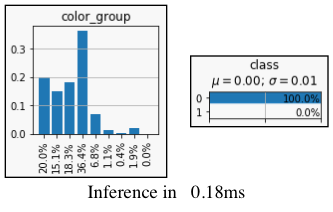

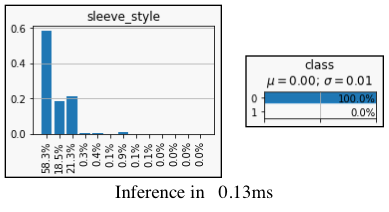

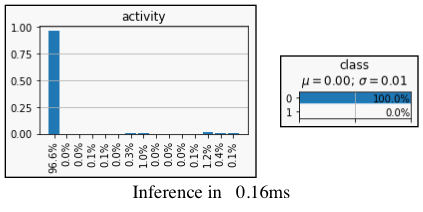

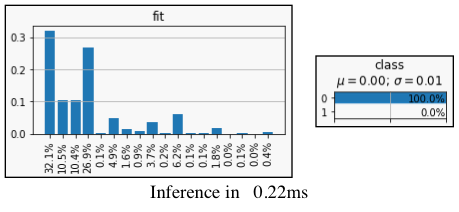

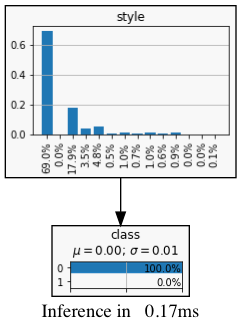

***** [9.99875361e-01 1.24638548e-04] [0.03333333 0.96666667] style elegant
0.9994261829697563 [-3.40107274  8.95619107]
thresh 0.9994261829697563
style elegant [0.03333333 0.96666667]
k [-3.40107274  8.95619107]
0.9666666666666666 [-1.55367042e-08  9.66542013e-01]
***** [9.99875361e-01 1.24638548e-04] [9.99990057e-01 9.94253216e-06] style classic
0.9994261829697563 [ 1.14703735e-04 -2.52859620e+00]
thresh 0.9994261829697563
style classic [9.99990057e-01 9.94253216e-06]
k [ 1.14703735e-04 -2.52859620e+00]
9.94253216409155e-06 [-1.55367042e-08 -1.14711553e-04]
***** [9.99875361e-01 1.24638548e-04] [9.99948912e-01 5.10881782e-05] style goingout
0.9994261829697563 [ 7.3556833e-05 -8.9186481e-01]
thresh 0.9994261829697563
style goingout [9.99948912e-01 5.10881782e-05]
k [ 7.3556833e-05 -8.9186481e-01]
5.108817819556553e-05 [-1.55367042e-08 -7.35659067e-05]
***** [9.99875361e-01 1.24638548e-04] [9.99963070e-01 3.69303494e-05] style occasion
0.9994261829697563 [ 8.77152849e-05 -1.21638425e+0

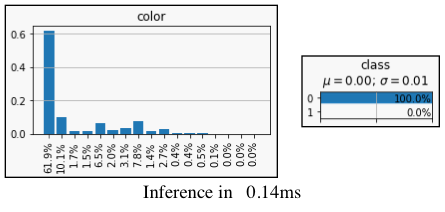

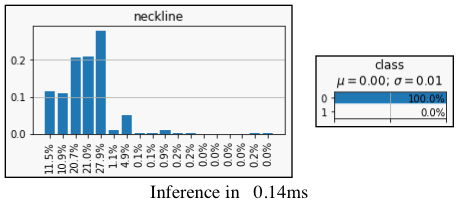

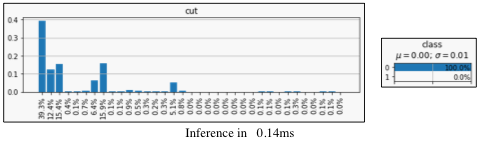

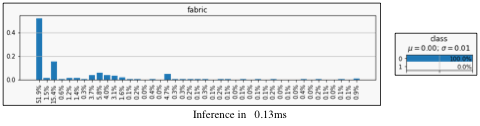

../data_docs/shirt#male#dress_code_creative black tie.csv
dress code size 417


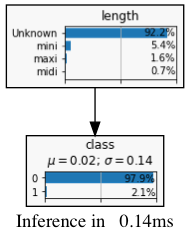

***** [0.97918536 0.02081464] [9.99885557e-01 1.14442664e-04] length mini
0.908595799892044 [ 0.02091987 -5.2033378 ]
thresh 0.908595799892044
length mini [9.99885557e-01 1.14442664e-04]
k [ 0.02091987 -5.2033378 ]
0.00011444266422522316 [-0.00044246 -0.02114265]
***** [0.97918536 0.02081464] [9.99620349e-01 3.79650721e-04] length maxi
0.908595799892044 [ 0.02065459 -4.00416007]
thresh 0.908595799892044
length maxi [9.99620349e-01 3.79650721e-04]
k [ 0.02065459 -4.00416007]
0.00037965072133637056 [-0.00044246 -0.02087745]
***** [0.97918536 0.02081464] [9.99151104e-01 8.48896435e-04] length midi
0.908595799892044 [ 0.02018506 -3.19947455]
thresh 0.908595799892044
length midi [9.99151104e-01 8.48896435e-04]
k [ 0.02018506 -3.19947455]
0.0008488964346349745 [-0.00044246 -0.0204082 ]


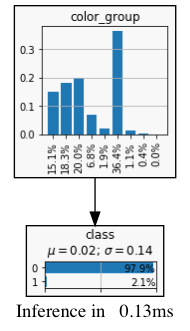

***** [0.97918536 0.02081464] [0.94904072 0.05095928] color_group pale
0.908595799892044 [-0.03126925  0.89537035]
thresh 0.908595799892044
color_group pale [0.94904072 0.05095928]
k [-0.03126925  0.89537035]
0.050959276683328426 [-0.00044246  0.02970218]
***** [0.97918536 0.02081464] [0.97867982 0.02132018] color_group dark
0.908595799892044 [-0.00051642  0.02399767]
thresh 0.908595799892044
color_group dark [0.97867982 0.02132018]
k [-0.00051642  0.02399767]
0.02132018209408194 [-4.42458755e-04  6.30857880e-05]
***** [0.97918536 0.02081464] [0.97643166 0.02356834] color_group bright
0.908595799892044 [-0.0028162   0.12424765]
thresh 0.908595799892044
color_group bright [0.97643166 0.02356834]
k [-0.0028162   0.12424765]
0.023568335920267955 [-0.00044246  0.00231124]
***** [0.97918536 0.02081464] [0.74472086 0.25527914] color_group warm_color
0.908595799892044 [-0.2737115   2.50670116]
thresh 0.908595799892044
color_group warm_color [0.74472086 0.25527914]
k [-0.2737115   2.50670116]


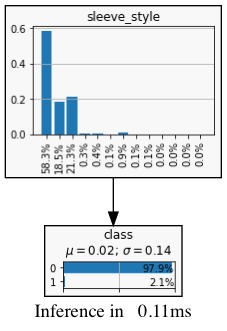

***** [0.97918536 0.02081464] [0.99164077 0.00835923] sleeve_style long_sleeve
0.908595799892044 [ 0.01263995 -0.91229023]
thresh 0.908595799892044
sleeve_style long_sleeve [0.99164077 0.00835923]
k [ 0.01263995 -0.91229023]
0.008359229334990679 [-0.00044246 -0.01289787]
***** [0.97918536 0.02081464] [9.99054242e-01 9.45758498e-04] sleeve_style short_sleeve
0.908595799892044 [ 0.02008811 -3.0914245 ]
thresh 0.908595799892044
sleeve_style short_sleeve [9.99054242e-01 9.45758498e-04]
k [ 0.02008811 -3.0914245 ]
0.0009457584983156489 [-0.00044246 -0.02031134]
***** [0.97918536 0.02081464] [9.99348958e-01 6.51041667e-04] sleeve_style batwing
0.908595799892044 [ 0.02038306 -3.4648381 ]
thresh 0.908595799892044
sleeve_style batwing [9.99348958e-01 6.51041667e-04]
k [ 0.02038306 -3.4648381 ]
0.0006510416666666667 [-0.00044246 -0.02060605]
***** [0.97918536 0.02081464] [9.99537037e-01 4.62962963e-04] sleeve_style drop_shoulder
0.908595799892044 [ 0.02057125 -3.80576469]
thresh 0.90859579989204

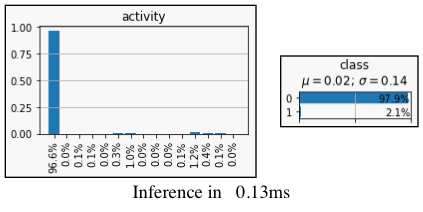

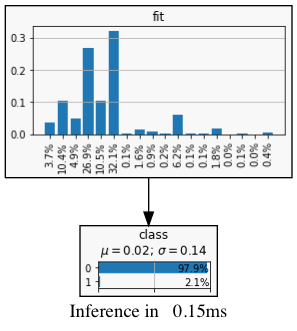

***** [0.97918536 0.02081464] [0.98365914 0.01634086] fit classicfit
0.908595799892044 [ 0.00455848 -0.241988  ]
thresh 0.908595799892044
fit classicfit [0.98365914 0.01634086]
k [ 0.00455848 -0.241988  ]
0.016340855913653862 [-0.00044246 -0.00491624]
***** [0.97918536 0.02081464] [0.91043678 0.08956322] fit skinny
0.908595799892044 [-0.0727965   1.45928825]
thresh 0.908595799892044
fit skinny [0.91043678 0.08956322]
k [-0.0727965   1.45928825]
0.08956321716104527 [-0.00044246  0.06830612]
***** [0.97918536 0.02081464] [0.99793517 0.00206483] fit regular_fit
0.908595799892044 [ 0.01896735 -2.31060857]
thresh 0.908595799892044
fit regular_fit [0.99793517 0.00206483]
k [ 0.01896735 -2.31060857]
0.0020648300050913615 [-0.00044246 -0.01919227]
***** [0.97918536 0.02081464] [0.98186033 0.01813967] fit slim
0.908595799892044 [ 0.00272811 -0.13755528]
thresh 0.908595799892044
fit slim [0.98186033 0.01813967]
k [ 0.00272811 -0.13755528]
0.01813966876728383 [-0.00044246 -0.00311743]
***** [0.97

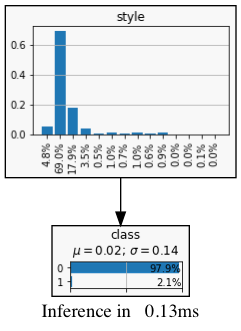

***** [0.97918536 0.02081464] [0.73214418 0.26785582] style occasion
0.908595799892044 [-0.29074351  2.5547924 ]
thresh 0.908595799892044
style occasion [0.73214418 0.26785582]
k [-0.29074351  2.5547924 ]
0.26785582391609425 [-0.00044246  0.24659873]
***** [0.97918536 0.02081464] [9.99990057e-01 9.94253216e-06] style classic
0.908595799892044 [ 0.02102437 -7.64659001]
thresh 0.908595799892044
style classic [9.99990057e-01 9.94253216e-06]
k [ 0.02102437 -7.64659001]
9.94253216409155e-06 [-0.00044246 -0.02124715]
***** [0.97918536 0.02081464] [9.99948912e-01 5.10881782e-05] style goingout
0.908595799892044 [ 0.02098323 -6.00985862]
thresh 0.908595799892044
style goingout [9.99948912e-01 5.10881782e-05]
k [ 0.02098323 -6.00985862]
5.108817819556553e-05 [-0.00044246 -0.02120601]
***** [0.97918536 0.02081464] [9.99607843e-01 3.92156863e-04] style fancy
0.908595799892044 [ 0.02064208 -3.97174983]
thresh 0.908595799892044
style fancy [9.99607843e-01 3.92156863e-04]
k [ 0.02064208 -3.97174983]

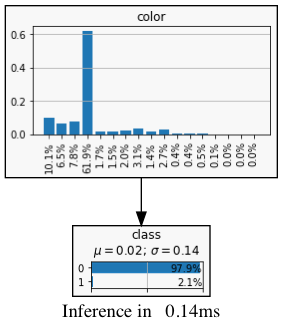

***** [0.97918536 0.02081464] [0.96890598 0.03109402] color blue
0.908595799892044 [-0.01055339  0.40135912]
thresh 0.908595799892044
color blue [0.96890598 0.03109402]
k [-0.01055339  0.40135912]
0.031094022054556008 [-0.00044246  0.00983693]
***** [0.97918536 0.02081464] [0.94057432 0.05942568] color black
0.908595799892044 [-0.04023029  1.04906997]
thresh 0.908595799892044
color black [0.94057432 0.05942568]
k [-0.04023029  1.04906997]
0.05942567870262522 [-0.00044246  0.03816858]
***** [0.97918536 0.02081464] [0.91836465 0.08163535] color white
0.908595799892044 [-0.06412643  1.36660595]
thresh 0.908595799892044
color white [0.91836465 0.08163535]
k [-0.06412643  1.36660595]
0.08163535326806033 [-0.00044246  0.06037826]
***** [0.97918536 0.02081464] [0.98799318 0.01200682] color pattern
0.908595799892044 [ 0.00895483 -0.55018127]
thresh 0.908595799892044
color pattern [0.98799318 0.01200682]
k [ 0.00895483 -0.55018127]
0.012006824482832159 [-0.00044246 -0.00925027]
***** [0.9791853

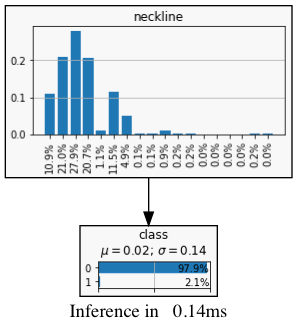

***** [0.97918536 0.02081464] [9.99045789e-01 9.54211032e-04] neckline point_collar
0.908595799892044 [ 0.02007965 -3.08252689]
thresh 0.908595799892044
neckline point_collar [9.99045789e-01 9.54211032e-04]
k [ 0.02007965 -3.08252689]
0.0009542110319956831 [-0.00044246 -0.02030289]
***** [0.97918536 0.02081464] [0.97318086 0.02681914] neckline collar
0.908595799892044 [-0.00615102  0.25345947]
thresh 0.908595799892044
neckline collar [0.97318086 0.02681914]
k [-0.00615102  0.25345947]
0.026819143336676832 [-0.00044246  0.00556205]
***** [0.97918536 0.02081464] [9.99031098e-01 9.68901600e-04] neckline button_collar
0.908595799892044 [ 0.02006494 -3.06724869]
thresh 0.908595799892044
neckline button_collar [9.99031098e-01 9.68901600e-04]
k [ 0.02006494 -3.06724869]
0.0009689015996899515 [-0.00044246 -0.02028819]
***** [0.97918536 0.02081464] [9.99874340e-01 1.25659713e-04] neckline v_neck
0.908595799892044 [ 0.02090865 -5.10983418]
thresh 0.908595799892044
neckline v_neck [9.99874340e-01

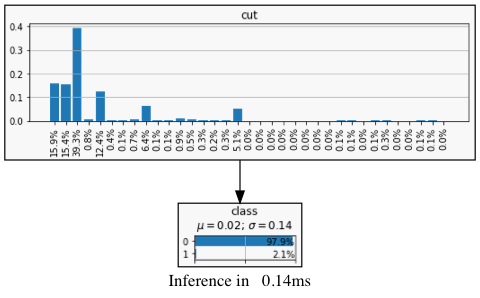

***** [0.97918536 0.02081464] [0.99623498 0.00376502] cut pocket
0.9085957998920441 [ 0.01726219 -1.70990335]
thresh 0.9085957998920441
cut pocket [0.99623498 0.00376502]
k [ 0.01726219 -1.70990335]
0.00376501978761886 [-0.00044246 -0.01749208]
***** [0.97918536 0.02081464] [0.91982733 0.08017267] cut button
0.9085957998920441 [-0.062535    1.34852621]
thresh 0.9085957998920441
cut button [0.91982733 0.08017267]
k [-0.062535    1.34852621]
0.08017266960940689 [-0.00044246  0.05891557]
***** [0.97918536 0.02081464] [0.8147593 0.1852407] cut crisscross
0.9085957998920441 [-0.18382823  2.18599958]
thresh 0.9085957998920441
cut crisscross [0.8147593 0.1852407]
k [-0.18382823  2.18599958]
0.18524069828954332 [-0.00044246  0.1639836 ]
***** [0.97918536 0.02081464] [9.99593803e-01 4.06197080e-04] cut button_down
0.9085957998920441 [ 0.02062804 -3.93657329]
thresh 0.9085957998920441
cut button_down [9.99593803e-01 4.06197080e-04]
k [ 0.02062804 -3.93657329]
0.00040619707995789286 [-0.00044246 

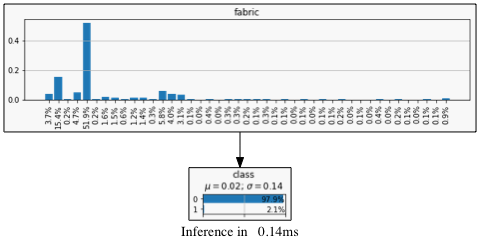

***** [0.97918536 0.02081464] [0.98400632 0.01599368] fabric poplin
0.9085957998920441 [ 0.00491135 -0.26346263]
thresh 0.9085957998920441
fabric poplin [0.98400632 0.01599368]
k [ 0.00491135 -0.26346263]
0.015993683037096675 [-0.00044246 -0.00526341]
***** [0.97918536 0.02081464] [0.91928371 0.08071629] fabric cotton
0.9085957998920441 [-0.06312617  1.35528393]
thresh 0.9085957998920441
fabric cotton [0.91928371 0.08071629]
k [-0.06312617  1.35528393]
0.08071628874683393 [-0.00044246  0.05945919]
***** [0.97918536 0.02081464] [0.11790841 0.88209159] fabric weave
0.9085957998920441 [-2.11681285  3.74663943]
thresh 0.9085957998920441
fabric weave [0.11790841 0.88209159]
k [-2.11681285  3.74663943]
0.8820915926179084 [-4.42458755e-04  8.60834496e-01]
***** [0.97918536 0.02081464] [0.97648389 0.02351611] fabric polyester
0.9085957998920441 [-0.00276271  0.12202934]
thresh 0.9085957998920441
fabric polyester [0.97648389 0.02351611]
k [-0.00276271  0.12202934]
0.02351611220154538 [-0.000442

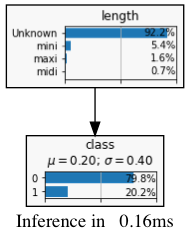

***** [0.79751221 0.20248779] [0.93305104 0.06694896] length mini
0.3935722133524661 [ 0.15696276 -1.10674905]
thresh 0.3935722133524661
length mini [0.93305104 0.06694896]
k [ 0.15696276 -1.10674905]
0.06694895857175555 [-0.05141151 -0.18695033]
***** [0.79751221 0.20248779] [0.79612756 0.20387244] length maxi
0.3935722133524661 [-0.00173772  0.00681493]
thresh 0.3935722133524661
length maxi [0.79612756 0.20387244]
k [-0.00173772  0.00681493]
0.20387243735763097 [-0.05141151 -0.05002685]
***** [0.79751221 0.20248779] [0.98556876 0.01443124] length midi
0.3935722133524661 [ 0.21172175 -2.64128431]
thresh 0.3935722133524661
length midi [0.98556876 0.01443124]
k [ 0.21172175 -2.64128431]
0.014431239388794566 [-0.05141151 -0.23946805]


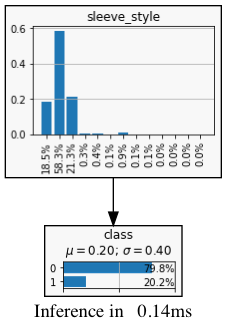

***** [0.79751221 0.20248779] [0.74332919 0.25667081] sleeve_style long_sleeve
0.39357221335246634 [-0.07035815  0.2371148 ]
thresh 0.39357221335246634
sleeve_style long_sleeve [0.74332919 0.25667081]
k [-0.07035815  0.2371148 ]
0.2566708100269319 [-0.05141151  0.00277152]
***** [0.79751221 0.20248779] [0.89835348 0.10164652] sleeve_style short_sleeve
0.39357221335246634 [ 0.11906647 -0.68917826]
thresh 0.39357221335246634
sleeve_style short_sleeve [0.89835348 0.10164652]
k [ 0.11906647 -0.68917826]
0.10164652050944858 [-0.05141151 -0.15225277]
***** [0.79751221 0.20248779] [0.93164062 0.06835938] sleeve_style batwing
0.39357221335246634 [ 0.15544999 -1.08590085]
thresh 0.39357221335246634
sleeve_style batwing [0.93164062 0.06835938]
k [ 0.15544999 -1.08590085]
0.068359375 [-0.05141151 -0.18553992]
***** [0.79751221 0.20248779] [0.95138889 0.04861111] sleeve_style drop_shoulder
0.39357221335246634 [ 0.17642575 -1.42682744]
thresh 0.39357221335246634
sleeve_style drop_shoulder [0.951388

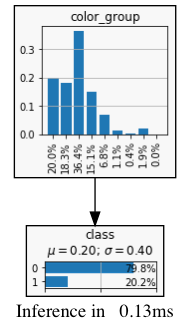

***** [0.79751221 0.20248779] [0.78611533 0.21388467] color_group dark
0.39357221335246617 [-0.01439364  0.0547574 ]
thresh 0.39357221335246617
color_group dark [0.78611533 0.21388467]
k [-0.01439364  0.0547574 ]
0.21388467374810316 [-0.05141151 -0.04001462]
***** [0.79751221 0.20248779] [0.82655219 0.17344781] color_group pattern
0.39357221335246617 [ 0.03576591 -0.15480279]
thresh 0.39357221335246617
color_group pattern [0.82655219 0.17344781]
k [ 0.03576591 -0.15480279]
0.17344781431569983 [-0.05141151 -0.08045148]
***** [0.79751221 0.20248779] [0.70492135 0.29507865] color_group pale
0.39357221335246617 [-0.12341092  0.37656238]
thresh 0.39357221335246617
color_group pale [0.70492135 0.29507865]
k [-0.12341092  0.37656238]
0.29507865333725375 [-0.05141151  0.04117936]
***** [0.79751221 0.20248779] [0.76909566 0.23090434] color_group bright
0.39357221335246617 [-0.03628179  0.13132394]
thresh 0.39357221335246617
color_group bright [0.76909566 0.23090434]
k [-0.03628179  0.13132394]


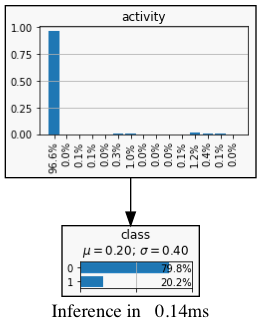

***** [0.79751221 0.20248779] [0.66483516 0.33516484] activity city
0.39357221335246634 [-0.18195801  0.50394289]
thresh 0.39357221335246634
activity city [0.66483516 0.33516484]
k [-0.18195801  0.50394289]
0.33516483516483514 [-0.05141151  0.08126554]
***** [0.79751221 0.20248779] [0.99778761 0.00221239] activity skateboarding
0.39357221335246634 [ 0.22404329 -4.51660647]
thresh 0.39357221335246634
activity skateboarding [0.99778761 0.00221239]
k [ 0.22404329 -4.51660647]
0.0022123893805309734 [-0.05141151 -0.2516869 ]
***** [0.79751221 0.20248779] [0.99841772 0.00158228] activity jungle
0.39357221335246634 [ 0.2246746  -4.85181368]
thresh 0.39357221335246634
activity jungle [0.99841772 0.00158228]
k [ 0.2246746  -4.85181368]
0.0015822784810126582 [-0.05141151 -0.25231701]
***** [0.79751221 0.20248779] [0.99450549 0.00549451] activity mountain
0.39357221335246634 [ 0.22074847 -3.60693097]
thresh 0.39357221335246634
activity mountain [0.99450549 0.00549451]
k [ 0.22074847 -3.60693097]


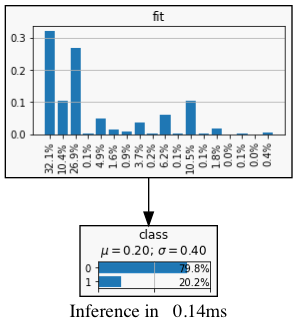

***** [0.79751221 0.20248779] [0.90831038 0.09168962] fit regular
0.39357221335246617 [ 0.130089   -0.79227042]
thresh 0.39357221335246617
fit regular [0.90831038 0.09168962]
k [ 0.130089   -0.79227042]
0.09168961676925867 [-0.05141151 -0.16220967]
***** [0.79751221 0.20248779] [0.62204777 0.37795223] fit skinny
0.39357221335246617 [-0.24848026  0.62408824]
thresh 0.39357221335246617
fit skinny [0.62204777 0.37795223]
k [-0.24848026  0.62408824]
0.3779522293845454 [-0.05141151  0.12405294]
***** [0.79751221 0.20248779] [0.65321826 0.34678174] fit slim
0.39357221335246617 [-0.19958583  0.53801602]
thresh 0.39357221335246617
fit slim [0.65321826 0.34678174]
k [-0.19958583  0.53801602]
0.3467817379951271 [-0.05141151  0.09288245]
***** [0.79751221 0.20248779] [0.14356436 0.85643564] fit super_skinny
0.39357221335246617 [-1.71471374  1.44209961]
thresh 0.39357221335246617
fit super_skinny [0.14356436 0.85643564]
k [-1.71471374  1.44209961]
0.8564356435643564 [-0.05141151  0.60253635]
*****

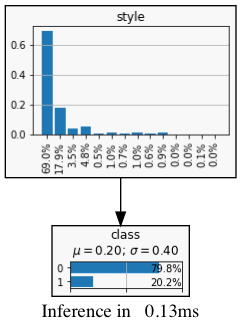

***** [0.79751221 0.20248779] [0.69543041 0.30456959] style classic
0.3935722133524662 [-0.1369662   0.40822003]
thresh 0.3935722133524662
style classic [0.69543041 0.30456959]
k [-0.1369662   0.40822003]
0.30456958778261645 [-0.05141151  0.0506703 ]
***** [0.79751221 0.20248779] [0.35766834 0.64233166] style goingout
0.3935722133524662 [-0.80189103  1.15442522]
thresh 0.3935722133524662
style goingout [0.35766834 0.64233166]
k [-0.80189103  1.15442522]
0.6423316644528456 [-0.05141151  0.38843237]
***** [0.79751221 0.20248779] [0.79522121 0.20477879] style occasion
0.3935722133524662 [-0.00287682  0.01125074]
thresh 0.3935722133524662
style occasion [0.79522121 0.20477879]
k [-0.00287682  0.01125074]
0.20477878720732698 [-0.05141151 -0.0491205 ]
***** [0.79751221 0.20248779] [0.98862745 0.01137255] style fancy
0.3935722133524662 [ 0.21482042 -2.8794771 ]
thresh 0.3935722133524662
style fancy [0.98862745 0.01137255]
k [ 0.21482042 -2.8794771 ]
0.011372549019607842 [-0.05141151 -0.242526

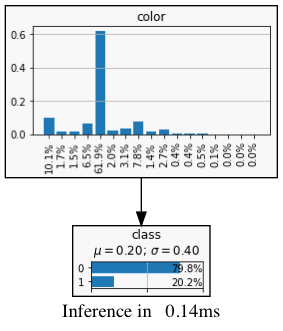

***** [0.79751221 0.20248779] [0.77058909 0.22941091] color blue
0.3935722133524663 [-0.03434188  0.1248352 ]
thresh 0.3935722133524663
color blue [0.77058909 0.22941091]
k [-0.03434188  0.1248352 ]
0.22941091120139293 [-0.05141151 -0.02448838]
***** [0.79751221 0.20248779] [0.83327499 0.16672501] color green
0.3935722133524663 [ 0.04386655 -0.19433374]
thresh 0.3935722133524663
color green [0.83327499 0.16672501]
k [ 0.04386655 -0.19433374]
0.1667250131279538 [-0.05141151 -0.08717428]
***** [0.79751221 0.20248779] [0.86682055 0.13317945] color brown
0.3935722133524663 [ 0.08333483 -0.41898213]
thresh 0.3935722133524663
color brown [0.86682055 0.13317945]
k [ 0.08333483 -0.41898213]
0.13317944600562023 [-0.05141151 -0.12071984]
***** [0.79751221 0.20248779] [0.76998029 0.23001971] color black
0.3935722133524663 [-0.03513224  0.12748544]
thresh 0.3935722133524663
color black [0.76998029 0.23001971]
k [-0.03513224  0.12748544]
0.23001971149538572 [-0.05141151 -0.02387958]
***** [0.797512

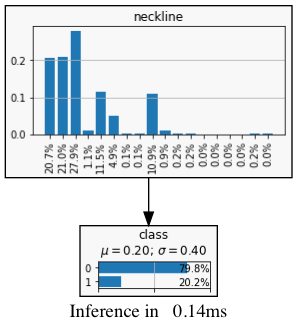

***** [0.79751221 0.20248779] [0.78782391 0.21217609] neckline button_collar
0.3935722133524662 [-0.01222255  0.04673696]
thresh 0.3935722133524662
neckline button_collar [0.78782391 0.21217609]
k [-0.01222255  0.04673696]
0.21217608617210365 [-0.05141151 -0.0417232 ]
***** [0.79751221 0.20248779] [0.739632 0.260368] neckline point_collar
0.3935722133524662 [-0.07534438  0.25141644]
thresh 0.3935722133524662
neckline point_collar [0.739632 0.260368]
k [-0.07534438  0.25141644]
0.2603679964200634 [-0.05141151  0.00646871]
***** [0.79751221 0.20248779] [0.80746924 0.19253076] neckline collar
0.3935722133524662 [ 0.01240781 -0.05042362]
thresh 0.3935722133524662
neckline collar [0.80746924 0.19253076]
k [ 0.01240781 -0.05042362]
0.1925307618205834 [-0.05141151 -0.06136853]
***** [0.79751221 0.20248779] [0.90939935 0.09060065] neckline v_neck
0.3935722133524662 [ 0.13128717 -0.80421814]
thresh 0.3935722133524662
neckline v_neck [0.90939935 0.09060065]
k [ 0.13128717 -0.80421814]
0.09060065

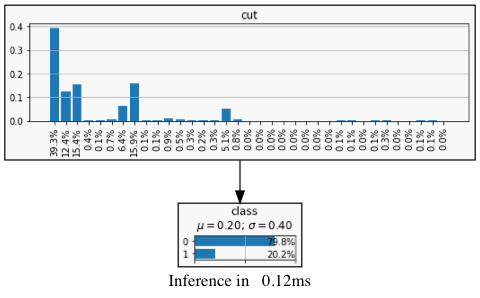

***** [0.79751221 0.20248779] [0.88065243 0.11934757] cut button_down
0.3935722133524665 [ 0.09916588 -0.5286396 ]
thresh 0.3935722133524665
cut button_down [0.88065243 0.11934757]
k [ 0.09916588 -0.5286396 ]
0.11934756739438877 [-0.05141151 -0.13455172]
***** [0.79751221 0.20248779] [0.82602749 0.17397251] cut button
0.3935722133524665 [ 0.0351309  -0.15178225]
thresh 0.3935722133524665
cut button [0.82602749 0.17397251]
k [ 0.0351309  -0.15178225]
0.17397251381727813 [-0.05141151 -0.07992678]
***** [0.79751221 0.20248779] [0.10404303 0.89595697] cut doublecuff
0.3935722133524665 [-2.03669262  1.48721283]
thresh 0.3935722133524665
cut doublecuff [0.10404303 0.89595697]
k [-2.03669262  1.48721283]
0.8959569732937684 [-0.05141151  0.64205768]
***** [0.79751221 0.20248779] [0.85641548 0.14358452] cut onebutton
0.3935722133524665 [ 0.07125848 -0.3437557 ]
thresh 0.3935722133524665
cut onebutton [0.85641548 0.14358452]
k [ 0.07125848 -0.3437557 ]
0.14358452138492872 [-0.05141151 -0.1103147

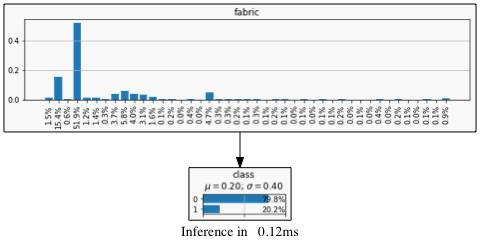

***** [0.79751221 0.20248779] [0.74501425 0.25498575] fabric woven
0.3935722133524663 [-0.06809381  0.23052811]
thresh 0.3935722133524663
fabric woven [0.74501425 0.25498575]
k [-0.06809381  0.23052811]
0.254985754985755 [-0.05141151  0.00108646]
***** [0.79751221 0.20248779] [0.79740457 0.20259543] fabric cotton
0.3935722133524663 [-0.00013499  0.00053149]
thresh 0.3935722133524663
fabric cotton [0.79740457 0.20259543]
k [-0.00013499  0.00053149]
0.20259543480882886 [-0.05141151 -0.05130386]
***** [0.79751221 0.20248779] [0.49557613 0.50442387] fabric wovencotton
0.3935722133524663 [-0.47577616  0.91273736]
thresh 0.3935722133524663
fabric wovencotton [0.49557613 0.50442387]
k [-0.47577616  0.91273736]
0.5044238683127572 [-0.05141151  0.25052458]
***** [0.79751221 0.20248779] [0.5 0.5] fabric satin
0.3935722133524663 [-0.46688905  0.90392853]
thresh 0.3935722133524663
fabric satin [0.5 0.5]
k [-0.46688905  0.90392853]
0.5 [-0.05141151  0.24610071]
***** [0.79751221 0.20248779] [0.9746

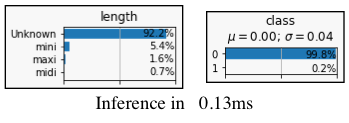

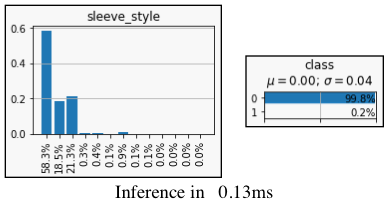

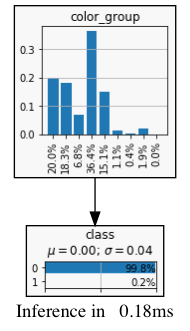

***** [0.99823013 0.00176987] [0.99370258 0.00629742] color_group dark
0.9918825850844144 [-0.0045459   1.26923546]
thresh 0.9918825850844144
color_group dark [0.99370258 0.00629742]
k [-0.0045459   1.26923546]
0.0062974203338391505 [-3.13798438e-06  4.52441496e-03]
***** [0.99823013 0.00176987] [0.99554775 0.00445225] color_group bright
0.9918825850844144 [-0.00269076  0.92250511]
thresh 0.9918825850844144
color_group bright [0.99554775 0.00445225]
k [-0.00269076  0.92250511]
0.004452250633118209 [-3.13798438e-06  2.67924526e-03]
***** [0.99823013 0.00176987] [9.99992395e-01 7.60502540e-06] color_group pattern
0.9918825850844144 [ 1.76383040e-03 -5.44985063e+00]
thresh 0.9918825850844144
color_group pattern [9.99992395e-01 7.60502540e-06]
k [ 1.76383040e-03 -5.44985063e+00]
7.605025400784838e-06 [-3.13798438e-06 -1.76540034e-03]
***** [0.99823013 0.00176987] [9.99981623e-01 1.83769480e-05] color_group pale
0.9918825850844144 [ 1.75305833e-03 -4.56756285e+00]
thresh 0.9918825850844144


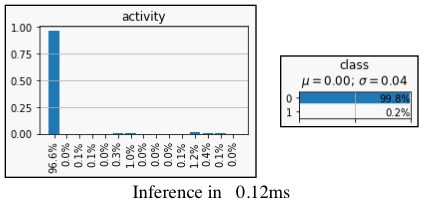

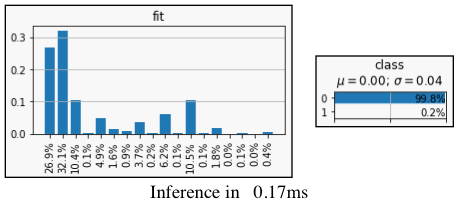

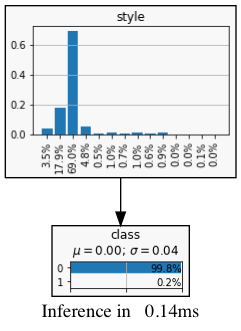

***** [0.99823013 0.00176987] [0.98278328 0.01721672] style goingout
0.9918825850844144 [-0.01559521  2.27497616]
thresh 0.9918825850844144
style goingout [0.98278328 0.01721672]
k [-0.01559521  2.27497616]
0.017216716051905587 [-3.13798438e-06  1.54437107e-02]
***** [0.99823013 0.00176987] [0.99664937 0.00335063] style classic
0.9918825850844144 [-0.00158482  0.63824476]
thresh 0.9918825850844144
style classic [0.99664937 0.00335063]
k [-0.00158482  0.63824476]
0.003350633339298853 [-3.13798438e-06  1.57762797e-03]
***** [0.99823013 0.00176987] [9.99963070e-01 3.69303494e-05] style occasion
0.9918825850844144 [ 1.73450442e-03 -3.86962621e+00]
thresh 0.9918825850844144
style occasion [9.99963070e-01 3.69303494e-05]
k [ 1.73450442e-03 -3.86962621e+00]
3.6930349361104953e-05 [-3.13798438e-06 -1.73607502e-03]
***** [0.99823013 0.00176987] [9.99607843e-01 3.92156863e-04] style fancy
0.9918825850844144 [ 1.37920167e-03 -1.50699798e+00]
thresh 0.9918825850844144
style fancy [9.99607843e-01 3

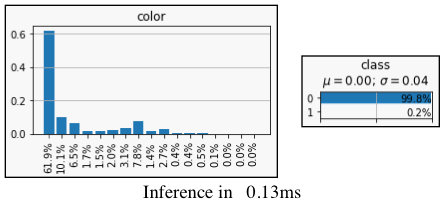

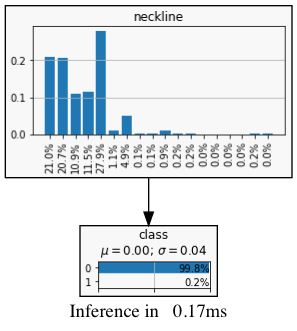

***** [0.99823013 0.00176987] [0.99525527 0.00474473] neckline point_collar
0.9918825850844144 [-0.00298459  0.98613035]
thresh 0.9918825850844144
neckline point_collar [0.99525527 0.00474473]
k [-0.00298459  0.98613035]
0.004744732097026811 [-3.13798438e-06  2.97172673e-03]
***** [0.99823013 0.00176987] [9.99031098e-01 9.68901600e-04] neckline button_collar
0.9918825850844144 [ 0.00080206 -0.60249684]
thresh 0.9918825850844144
neckline button_collar [9.99031098e-01 9.68901600e-04]
k [ 0.00080206 -0.60249684]
0.0009689015996899515 [-3.13798438e-06 -8.04103769e-04]
***** [0.99823013 0.00176987] [9.99552957e-01 4.47043472e-04] neckline reverecollar
0.9918825850844144 [ 1.32429202e-03 -1.37600406e+00]
thresh 0.9918825850844144
neckline reverecollar [9.99552957e-01 4.47043472e-04]
k [ 1.32429202e-03 -1.37600406e+00]
0.00044704347195708376 [-3.13798438e-06 -1.32596190e-03]
***** [0.99823013 0.00176987] [9.99995034e-01 4.96558847e-06] neckline collar
0.9918825850844144 [ 1.76646985e-03 -5.87

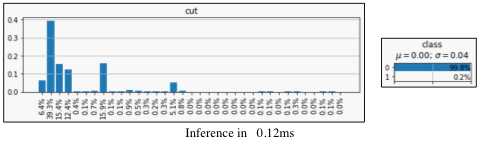

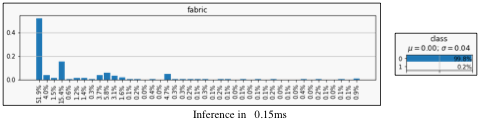

../data_docs/shirt#unisex#dress_code_casual.csv
dress code size 16


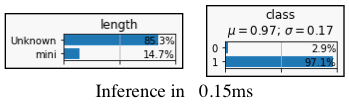

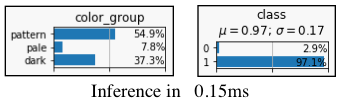

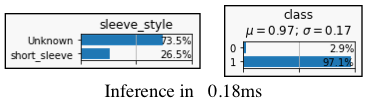

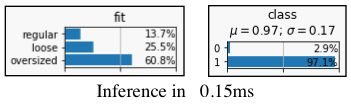

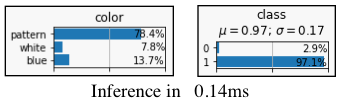

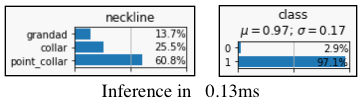

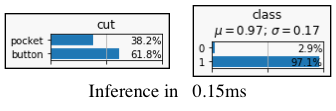

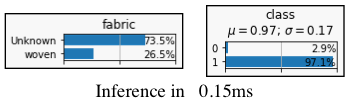

In [64]:
generate_aspect_effects(1)

In [59]:
gnb.showBN(template)


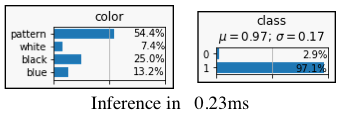

In [60]:
gnb.showInference(bn,size=40)

In [181]:
df_all_r

aspect                                                neg  \
0            cut  [ruffle, button, smock, tie_detail, frill, wra...   
1          color  [Unknown, brown, gray, nude, gold, orange, yel...   
2          style  [classic, feminine, boho, bohemian, flattering...   
3         length                           [short, long, mid, mini]   
4    color_group                                [Unknown, metallic]   
5         fabric  [woven_cotton, twill, pure_cotton, woven, crep...   
6       activity                            [beach, rock, baseball]   
7   sleeve_style                                                 []   
8            fit  [oversized, regular_fit, relaxed, regular, lon...   
9       neckline  [point_collar, collar, high_neck, crew_neck, o...   
0            cut                                                 []   
1          color  [pattern, blue, brown, gray, nude, orange, pur...   
2          style                                                 []   
3         length                                      [long, short]   
4    color_group                                                 []   
5         fabric                                                 []   
6       activity                            [Unknown, outdoor, gym]   
7   sleeve_style  [cold_shoulder, sleeveless, 3_4_sleeve, bell_s...   
8            fit  [longline, Unknown, skinny, classic_fit, slim,...   
9       neckline                                                 []   
0            cut                                                 []   
1          color                                                 []   
2          style                                                 []   
3         length                                      [long, short]   
4    color_group                                                 []   
5         fabric                                                 []   
6       activity                                                 []   
7   sleeve_style                                                 []   
8            fit  [longline, loose, skinny, classic_fit, slim, f...   
9       neckline                                                 []   
..           ...                                                ...   
8            fit  [regular_fit, super_skinny, muscle_fit, tailor...   
9       neckline  [point_collar, collar_button, v_neck, revere_c...   
0            cut  [zip, button_up, hood, raw_hem, distressed, wi...   
1          color                           [gold, off_white, solid]   
2          style  [fancy, western, color_block, colour_block, vi...   
3         length                          [short, mid, maxi, floor]   
4    color_group                               [warm_color, washed]   
5         fabric  [pure_cotton, jersey, denim, mesh, weave, silk...   
6       activity  [skateboarding, jungle, mountain, beach, outdo...   
7   sleeve_style  [batwing, drop_shoulder, dropshoulder, contras...   
8            fit  [tailored, longline, oversized, relaxed, skate...   
9       neckline  [revere_collar, crew_neck, polo_collar, deep_v...   
0            cut                                                 []   
1          color  [green, brown, red, gray, white, pink, pattern...   
2          style  [occasion, fancy, western, retro, stylish, col...   
3         length                                                 []   
4    color_group            [pattern, pale, cool_color, warm_color]   
5         fabric                                                 []   
6       activity                                                 []   
7   sleeve_style                                                 []   
8            fit  [muscle_fit, tailored, classic_fit, longline, ...   
9       neckline  [revere_collar, collar, v_neck, grandad, mini_...   
0            cut                                                 []   
1          color                                                 []   
2         length                  

In [ ]:
]